<a href="https://colab.research.google.com/github/justdepie/Classification-of-Scientific-Papers/blob/main/Data_Science_Challenge_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

--------------------------------------------------------------------------------
# **Data Science Challenge**
------------------------------------------------------------------------------

**Team Members:**
* Despoina Angelonidi (f3352201)
* Eirini Mylona (f3352214)
* Christos Stavropoulos (f3352216)





In this project, we have to deal with a classification problem. More specifically, given a citation of network which consists of thousands of research papers, the papers abstracts, their list of authors and their year of publication the goal is to built a model for predicting the class label of each research paper. In order to achieve this, we tried to aproach the solution of the specific classification problem with different techniques.
Each technique is implemented and analysed below.


# **Import the data from dropbox**

In [ ]:
# Import the files
%%capture
!wget -O edgelist.txt https://www.dropbox.com/s/w1trtswriyoz8c5/edgelist.txt?dl=0
!wget -O abstract.txt https://www.dropbox.com/s/yg7i5mg8su3l6s3/abstract.txt?dl=0
!wget -O authors_v2.txt https://www.dropbox.com/s/6b3snc1znfuxe38/authors_v2.txt?dl=0
!wget -O year.txt https://www.dropbox.com/s/otmj8o7l1dbu1sp/year.txt?dl=0
!wget -O y_train.txt https://www.dropbox.com/s/o51no5u147x61ag/y_train.txt?dl=0d
!wget -O test.txt https://www.dropbox.com/s/xawfic7x06s219e/test.txt?dl=0

# **Load necessary Libraries**

Here, we import the appropriate libraries.

In [ ]:
import re
import csv
import nltk
import numpy as np
import pandas as pd
import networkx as nx
from tqdm import tqdm
from sklearn.svm import SVC
from sklearn.decomposition import TruncatedSVD # SVD
from nltk.corpus import stopwords
from keras.utils import to_categorical  # test
from nltk.tokenize import word_tokenize
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split, ShuffleSplit, learning_curve, GridSearchCV

import matplotlib.pyplot as plt
from random import choice
from gensim.models import Word2Vec


In [ ]:
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('punkt')
#!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/ # unzip file kaggle only

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# **Read the Data**





## Train Data

In [ ]:
# Read abstracts of research papers
abstracts = dict()
with open("abstract.txt", "r", encoding="utf8") as f:
  for line in f:
    t = line.split('||')
    abstracts[int(t[0])] = t[1][:-1]

In [ ]:
# Read year of research papers
years = dict()
with open("year.txt", "r", encoding="utf8") as f:
  for line in f:
    t = line.split(',')
    years[int(t[0])] = t[1][:-1]

In [ ]:
# Read authors of research papers
authors = dict()
with open("authors_v2.txt", "r", encoding="utf8") as f:
  for line in f:
    t = line.split('||')
    authors[int(t[0])] = t[1][:-1]

In [ ]:
# Read training data
train_papers = list()
y_train = list()
with open("y_train.txt", "r") as f:
    for line in f:
        t = line.split(',')
        train_papers.append(int(t[0]))
        y_train.append(t[1][:-1])

In [ ]:
# Retrieve abstracts of papers of the training set
train_abstracts = [abstracts[node] for node in train_papers]
train_abstracts[:2]

["The CFG recognition problem is: given a context-free grammar G and a string w of length n, decide if w can be obtained from G. This is the most basic parsing question and is a core computer science problem. Valiant's parser from 1975 solves the problem in O(nO) time, where ? < 2:373 is the matrix multiplication exponent. Dozens of parsing algorithms have been proposed over the years, yet Valiant's upper bound remains unbeaten. The best combinatorial algorithms have mildly subcubic O(n3= log3 n) complexity. Lee (JACM'01) provided evidence that fast matrix multiplication is needed for CFG parsing, and that very efficient and practical algorithms might be hard or even impossible to obtain. Lee showed that any algorithm for a more general parsing problem with running time O(|G| n3 -- e) can be converted into a surprising subcubic algorithm for Boolean Matrix Multiplication. Unfortunately, Lee' s hardness result required that the grammar size be |G| = O(n6). Nothing was known for the more

In [ ]:
# Retrieve years of papers of the training set
train_years = [years[node] for node in train_papers]
train_years[:4]

['2015', '2011', '2014', '2016']

In [ ]:
# Retrieve authors of papers of the training set
train_authors = [authors[node] for node in train_papers]
train_authors[:4]

['Amir Abboud|*Arturs Backurs|*Virginia Vassilevska Williams',
 'David C. Anastasiu|*Byron J. Gao|*David Buttler',
 'Kar, Purushottam|*Narasimhan, Harikrishna|*Prateek Jain 0002',
 'Niepert, Mathias']

In [ ]:
y_train[:4]

['4', '3', '0', '0']

## Test Data

In [ ]:
# Read test data
test_papers = list()
with open("test.txt", "r", encoding="utf8") as f:
    for line in f:
        t = line.split(',')
        test_papers.append(int(t[0]))

In [ ]:
# Retrieve abstracts of papers of the test set
test_abstracts = [abstracts[node] for node in test_papers]
test_abstracts[:2]

['This paper proposes a learning-based approach to scene parsing inspired by the deep Recursive Context Propagation Network (RCPN). RCPN is a deep feed-forward neural network that utilizes the contextual information from the entire image, through bottom-up followed by top-down context propagation via random binary parse trees. This improves the feature representation of every super-pixel in the image for better classification into semantic categories. We analyze RCPN and propose two novel contributions to further improve the model. We first analyze the learning of RCPN parameters and discover the presence of bypass error paths in the computation graph of RCPN that can hinder contextual propagation. We propose to tackle this problem by including the classification loss of the internal nodes of the random parse trees in the original RCPN loss function. Secondly, we use an MRF on the parse tree nodes to model the hierarchical dependency present in the output. Both modifications provide pe

In [ ]:
test_years = [years[node] for node in test_papers]
test_years[:4]

['2015', '2011', '2007', '2000']

In [ ]:
test_authors = [authors[node] for node in test_papers]
test_authors[:4]

['Abhishek Sharma|*Oncel Tuzel|*David W. Jacobs',
 'Katja Hofmann|*Shimon Whiteson|*Maarten de Rijke',
 'Yun Fu|*Ming Liu|*Thomas S. Huang',
 'Hakan Ferhatosmanoglu|*Ertem Tuncel|*Divyakant Agrawal|*Amr El Abbadi']

# **1st Approach - Using Text Only**
We begin our classification journey by using only textual data. In this segment we will implement:
  
*   Logistic Regression using TF-IDF word embeddings
*   Multinomial Naive Bayes using TF-IDF word embeddings
*   biGRU RNN with self-attention using pretrained word embeddings from FastText.






In [ ]:
df_year=pd.DataFrame.from_dict(years,orient='index')
df_year=df_year.reset_index().rename(columns={'index':'id',0:'year'})
df_year

,id,year
0,0,2010
1,1,2007
2,2,2015
3,3,2011
4,4,1989
...,...,...
166981,166981,2014
166982,166982,1981
166983,166983,2010
166984,166984,2007


In [ ]:
# Create a dataFrame for authors
df_authors= pd.DataFrame.from_dict(authors, orient='index')
df_authors.reset_index(inplace=True)
df_authors =df_authors.rename(columns={'index': 'id'})
df_authors =df_authors.rename(columns={0: 'authors'})
df_authors

,id,authors
0,0,Junchi Yan|*Jian Liu|*Yin Li|*Zhibin Niu|*Yunc...
1,1,Mehdi M. Kashani|*Eric Joanis|*Roland Kuhn|*Ge...
2,2,Amir Abboud|*Arturs Backurs|*Virginia Vassilev...
3,3,David C. Anastasiu|*Byron J. Gao|*David Buttler
4,4,Giulia Pagallo
...,...,...
166981,166981,Jelani Nelson|*Eric Price|*Mary Wootters
166982,166982,"Karp, Richard M.|*Sipser, M."
166983,166983,Y. Mohammad|*T. Nishida
166984,166984,Jacob O. Wobbrock|*Andrew D. Wilson|*Yang Li


In [ ]:
# Create a dataframe for abstracts
df_abstracts= pd.DataFrame.from_dict(abstracts, orient='index')
df_abstracts.reset_index(inplace=True)
df_abstracts =df_abstracts.rename(columns={'index': 'id'})
df_abstracts =df_abstracts.rename(columns={0: 'all_abstracts'})
df_abstracts

,id,all_abstracts
0,0,Saliency mechanism has been considered crucial...
1,1,We provide an in-depth analysis of the integra...
2,2,The CFG recognition problem is: given a contex...
3,3,How to organize and present search results pla...
4,4,We investigate the problem of learning DNF con...
...,...,...
166981,166981,"In this paper, we present novel constructions ..."
166982,166982,
166983,166983,
166984,166984,"Although mobile, tablet, large display, and ta..."


In [ ]:
# Load y_train into a dataframe named df3
df_label=pd.DataFrame(y_train).reset_index()
df_label =df_label.rename(columns={'index': 'id',0:'label'})
df_label

,id,label
0,0,4
1,1,3
2,2,0
3,3,0
4,4,4
...,...,...
35158,35158,1
35159,35159,2
35160,35160,1
35161,35161,3


In [ ]:
# Merge the dataframes df_abstracts and df_year
df_merged=pd.merge(df_abstracts,df_authors, on='id', how='left')
df_merged=pd.merge(df_merged,df_year, on='id', how='left')
#df_merged=pd.merge(df_merged,df_label,on='id', how='left')
df_merged


,id,all_abstracts,authors,year
0,0,Saliency mechanism has been considered crucial...,Junchi Yan|*Jian Liu|*Yin Li|*Zhibin Niu|*Yunc...,2010
1,1,We provide an in-depth analysis of the integra...,Mehdi M. Kashani|*Eric Joanis|*Roland Kuhn|*Ge...,2007
2,2,The CFG recognition problem is: given a contex...,Amir Abboud|*Arturs Backurs|*Virginia Vassilev...,2015
3,3,How to organize and present search results pla...,David C. Anastasiu|*Byron J. Gao|*David Buttler,2011
4,4,We investigate the problem of learning DNF con...,Giulia Pagallo,1989
...,...,...,...,...
166981,166981,"In this paper, we present novel constructions ...",Jelani Nelson|*Eric Price|*Mary Wootters,2014
166982,166982,,"Karp, Richard M.|*Sipser, M.",1981
166983,166983,,Y. Mohammad|*T. Nishida,2010
166984,166984,"Although mobile, tablet, large display, and ta...",Jacob O. Wobbrock|*Andrew D. Wilson|*Yang Li,2007


## Language detection and translation - Google Translate

Since a signifficant part of our data is textual, we need to be aware of the language that they are written. In this segment we will detect the language and translate the abstracts that are not in english. To implement this we will use Google Translate.

In [ ]:
%%capture
!pip install googletrans==3.1.0a0

In [ ]:
# import libraries
import googletrans
from googletrans import Translator

In [ ]:
def prep_for_translation(corpus,list_name):

  for doc in tqdm(corpus):

      # Substitute multiple spaces with single space
      document = re.sub(r'\s+', ' ', str(doc), flags=re.I)

      # Convert to Lowercase
      document = document.lower()

      # Split the document based on whitespaces (--> List of words)
      document = document.split()

      # Reconstruct the document by joining the words on each whitespace
      document = ' '.join(document)

      # Append all documents into a list 'docs'
      list_name.append(document)

  return

In [ ]:
all_abstr_prep=[]
prep_for_translation(df_merged.all_abstracts, all_abstr_prep)

100%|██████████| 166986/166986 [00:13<00:00, 11987.47it/s]


### Detection:
First let's detect the language:

In [ ]:
def language_detection(corpus,language_list,confidence_list):
  # create a translator object
  translator = Translator()
  #detect the language
  for abstr in tqdm(corpus):
    language_list.append(translator.detect(abstr).lang)
    confidence_list.append(translator.detect(abstr).confidence)
  return

In [ ]:
#---μη με τρεξεις, κανω 3 παρα ωρες---
all_abstr_language_list=[]
all_abstr_confidence_list=[]
language_detection(all_abstr_prep,all_abstr_language_list,all_abstr_confidence_list)

100%|██████████| 166986/166986 [2:35:52<00:00, 17.86it/s]


In [ ]:
all_abstr_lang_detect= {'id':df_merged['id'],'all_abstracts':all_abstr_prep,'language':all_abstr_language_list,'confidence':all_abstr_confidence_list}
all_abstr_lang_detect_df=pd.DataFrame(all_abstr_lang_detect)
all_abstr_lang_detect_df

,id,all_abstracts,language,confidence
0,0,saliency mechanism has been considered crucial...,en,1
1,1,we provide an in-depth analysis of the integra...,en,0.984533
2,2,the cfg recognition problem is: given a contex...,en,1
3,3,how to organize and present search results pla...,en,0.983599
4,4,we investigate the problem of learning dnf con...,en,0.987837
...,...,...,...,...
166981,166981,"in this paper, we present novel constructions ...",en,0.955189
166982,166982,,en,0
166983,166983,,en,0
166984,166984,"although mobile, tablet, large display, and ta...",en,1


In [ ]:
#saving the dataframe to drive
google.colab import drive
drive.mount('/content/gdrive')
all_abstr_lang_detect_df.to_csv('all_abstr_lang_detect_df.csv')
!cp all_abstr_lang_detect_df.csv "/content/gdrive/MyDrive"


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Translation:

In [ ]:
%%capture
!wget -O all_abstr_lang_detect_df.csv https://www.dropbox.com/s/myqj678g2ip6nww/all_abstr_lang_detect_df.csv?dl=0
!wget -O all_abstracts_translated.csv https://www.dropbox.com/s/kppfynf0uhzybeb/all_abstracts_translated.csv?dl=0

In [ ]:
#importing the dataframes we saved above
all_abstr_lang_detect_df_import=pd.DataFrame(pd.read_csv('all_abstr_lang_detect_df.csv',index_col='Unnamed: 0'))
all_abstr_lang_detect_df_import.all_abstracts = all_abstr_lang_detect_df_import.all_abstracts.replace(np.nan,'')
all_abstr_lang_detect_df_import

<ipython-input-24-7919c3f206ca>:2: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  all_abstr_lang_detect_df_import=pd.DataFrame(pd.read_csv('all_abstr_lang_detect_df.csv',index_col='Unnamed: 0'))


,id,all_abstracts,language,confidence
0,0,saliency mechanism has been considered crucial...,en,1
1,1,we provide an in-depth analysis of the integra...,en,0.98453313
2,2,the cfg recognition problem is: given a contex...,en,1
3,3,how to organize and present search results pla...,en,0.98359936
4,4,we investigate the problem of learning dnf con...,en,0.98783743
...,...,...,...,...
166981,166981,"in this paper, we present novel constructions ...",en,0.955189
166982,166982,,en,0.0
166983,166983,,en,0.0
166984,166984,"although mobile, tablet, large display, and ta...",en,1.0


We notice that there is indeed non-english text present.

In [ ]:
all_abstr_lang_detect_df_import.language.value_counts()

en              166910
fr                  49
de                  10
ca                   7
['en', 'om']         1
nl                   1
af                   1
pt                   1
om                   1
el                   1
['en', 'ja']         1
['en', 'la']         1
jw                   1
sv                   1
Name: language, dtype: int64

Let's now locate the non-english abstracts:

In [ ]:
all_abstr_lang_detect_df_import[all_abstr_lang_detect_df_import.language!='en']

,id,all_abstracts,language,confidence
6692,6692,ohne zusammenfassung,de,1
9240,9240,résumé - abstract s’inscrivant dans les domain...,fr,0.8420154
10244,10244,the <em>suffix tree of alignment</em> is an in...,"['en', 'om']","[0.5763183, 0.36967072]"
10971,10971,la base de données et les tests noisex-92 sont...,fr,0.98587424
11470,11470,comunicacio presentada a la 2016 conference of...,ca,0.8882494
...,...,...,...,...
151845,151845,"linguistische diskurstheorien gehen davon aus,...",de,1.0
151975,151975,comunicacio presentada al 10th international w...,ca,1.0
159323,159323,les systèmes actuellement les plus performants...,fr,0.962446
160763,160763,comunicacio presentada a la 2018 conference on...,ca,0.798219


Using the function below we will translate all non-english text.

In [ ]:
# A function that translates non-english abstracts to english
def translation(df):
  translator = Translator()
  for i in tqdm(range(len(df))):
    if (df.language[i] != 'en'):
      df.all_abstracts[i]=translator.translate(df.all_abstracts[i]).text
      df.language[i]= translator.detect(translator.translate(df.all_abstracts[i]).text).lang

In [ ]:
 #translating
 translation(all_abstr_lang_detect_df_import)

  0%|          | 0/166986 [00:00<?, ?it/s]<ipython-input-27-2c072f5d31d4>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.all_abstracts[i]=translator.translate(df.all_abstracts[i]).text
<ipython-input-27-2c072f5d31d4>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.language[i]= translator.detect(translator.translate(df.all_abstracts[i]).text).lang
100%|██████████| 166986/166986 [00:35<00:00, 4758.33it/s]


There are some records that are not written in the language that the model predicted. Probably punctuation is to blame

In [ ]:
all_abstr_lang_detect_df_import[all_abstr_lang_detect_df_import.language!='en']

,id,all_abstracts,language,confidence
10244,10244,the <em>suffix tree of alignment</em> is an in...,"[en, om]","[0.5763183, 0.36967072]"
73974,73974,A new technique to recognize 3D free-form obje...,"[om, en]",0.676199
97486,97486,t ˆ r v t ) + σ 2 v σ 2 v +σ 2 p(p t ˆ r p t ),el,0.3306783
105806,105806,shimon ullman,"[en, ja]","[0.6212891, 0.3333014]"
110628,110628,a system for revising probabilis(cid:173),"[en, la]","[0.47982615, 0.44239166]"
146498,146498,dalancea,jw,0.754754
149900,149900,"dear bernt lindström,",sv,0.927612


In [ ]:
#let's substitute <em> with " "
all_abstr_lang_detect_df_import.all_abstracts = all_abstr_lang_detect_df_import.all_abstracts.apply(lambda x: re.sub('<em>','',x))

In [ ]:
# Remove non-word (special) characters such as punctuation etc
a=[]
for i in tqdm(range(len(all_abstr_lang_detect_df_import.all_abstracts))):
  a.append(re.sub(r'\W', ' ', all_abstr_lang_detect_df_import.all_abstracts[i]))
all_abstr_lang_detect_df_import.all_abstracts=a

100%|██████████| 166986/166986 [00:34<00:00, 4902.23it/s] 


In [ ]:
all_abstr_lang_detect_df_import[all_abstr_lang_detect_df_import.language!='en']

,id,all_abstracts,language,confidence
10244,10244,the suffix tree of alignment em is an index ...,"[en, om]","[0.5763183, 0.36967072]"
73974,73974,A new technique to recognize 3D free form obje...,"[om, en]",0.676199
97486,97486,t ˆ r v t σ 2 v σ 2 v σ 2 p p t ˆ r p t,el,0.3306783
105806,105806,shimon ullman,"[en, ja]","[0.6212891, 0.3333014]"
110628,110628,a system for revising probabilis cid 173,"[en, la]","[0.47982615, 0.44239166]"
146498,146498,dalancea,jw,0.754754
149900,149900,dear bernt lindström,sv,0.927612


In [ ]:
#let's see if now the model is able to recognize the correct language
translation(all_abstr_lang_detect_df_import)

  0%|          | 0/166986 [00:00<?, ?it/s]<ipython-input-27-2c072f5d31d4>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.all_abstracts[i]=translator.translate(df.all_abstracts[i]).text
<ipython-input-27-2c072f5d31d4>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.language[i]= translator.detect(translator.translate(df.all_abstracts[i]).text).lang
100%|██████████| 166986/166986 [00:04<00:00, 41700.49it/s]


Apparently changing ```
<em>
```
 to " " and removing the punctuation and the special characters didn't help much. We will leave it as it is for now.

In [ ]:
all_abstr_lang_detect_df_import[all_abstr_lang_detect_df_import.language!='en']

,id,all_abstracts,language,confidence
10244,10244,the suffix tree of alignment em is an index da...,"[en, om]","[0.5763183, 0.36967072]"
73974,73974,A new technique for recognizing 3D free form o...,"[en, om]",0.676199
97486,97486,t ˆ r v t σ 2 v σ 2 v σ 2 p p t ˆ r p t,el,0.3306783
105806,105806,shimon ullman,"[en, ja]","[0.6212891, 0.3333014]"
110628,110628,a system for revising probabilis cid 173,"[en, la]","[0.47982615, 0.44239166]"
146498,146498,dalancea,jw,0.754754
149900,149900,dear bernt lindström,sv,0.927612


## Train - Test dataframes creation

### Creating the train dataframe:


In [ ]:
#put the data into a dataframe
train_df=pd.DataFrame(train_abstracts)
#adding the id of each document
train_df['id']=train_papers
#renaming the column
train_df =train_df.rename(columns={0: 'train_abstracts'})
#adding the labels
train_df['label'] = y_train

Now we will merge the dataframe that contains all the translated abstracts with the dataframe that contains only the train data. Will implement an inner join using id as key.

In [ ]:
train_df_tr=pd.merge(train_df,all_abstr_lang_detect_df_import,on='id',how='inner')

The row included in the dataframe below contains illegible text. We will check the test dataframe next to see if any row similar to his one exists to see if we can drop it.

In [ ]:
train_df_tr[train_df_tr.language!='en']

,train_abstracts,id,label,all_abstracts,language,confidence
20627,t ˆ r v t ) + σ 2 v σ 2 v +σ 2 p(p t ˆ r p t ),97486,0,t ˆ r v t σ 2 v σ 2 v σ 2 p p t ˆ r p t,el,0.3306783


In [ ]:
#keeping only what is necessary
train_df_tr=train_df_tr.drop (['train_abstracts','language','confidence'],axis=1)
train_df_tr=train_df_tr.rename(columns={'all_abstracts': 'train_abstracts'})
train_df_tr

,id,label,train_abstracts
0,2,4,the cfg recognition problem is given a contex...
1,3,3,how to organize and present search results pla...
2,6,0,modern applications in sensitive domains such ...
3,8,0,we present discriminative gaifman models a no...
4,13,4,
...,...,...,...
35158,166969,1,multi modal clustering aims to cluster data in...
35159,166976,2,we present an nlp system that classifies the a...
35160,166977,1,deep learning researchers have a keen interest...
35161,166978,3,novelty coverage and balance are important re...


In [ ]:
df_authors['authors'] = df_authors['authors'].apply(lambda x: x.split("|*"))

In [ ]:
for i in tqdm(range(len(df_authors))):
  df_authors.authors.iloc[i]=str(df_authors.authors.iloc[i]).replace("[", "")
  df_authors.authors.iloc[i]=str(df_authors.authors.iloc[i]).replace("]", "")
  df_authors.authors.iloc[i]=str(df_authors.authors.iloc[i]).replace("'", "")
df_authors

  0%|          | 0/166986 [00:00<?, ?it/s]<ipython-input-42-4bce5b3132ea>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_authors.authors.iloc[i]=str(df_authors.authors.iloc[i]).replace("[", "")
<ipython-input-42-4bce5b3132ea>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_authors.authors.iloc[i]=str(df_authors.authors.iloc[i]).replace("]", "")
<ipython-input-42-4bce5b3132ea>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df

,id,authors
0,0,"Junchi Yan, Jian Liu, Yin Li, Zhibin Niu, Yunc..."
1,1,"Mehdi M. Kashani, Eric Joanis, Roland Kuhn, Ge..."
2,2,"Amir Abboud, Arturs Backurs, Virginia Vassilev..."
3,3,"David C. Anastasiu, Byron J. Gao, David Buttler"
4,4,Giulia Pagallo
...,...,...
166981,166981,"Jelani Nelson, Eric Price, Mary Wootters"
166982,166982,"Karp, Richard M., Sipser, M."
166983,166983,"Y. Mohammad, T. Nishida"
166984,166984,"Jacob O. Wobbrock, Andrew D. Wilson, Yang Li"


Now we will combine to a single dataframe all the available information for the tgraining data. Now we will perform left joins using id again as key.

In [ ]:
#merge the train abstracts dataframe with the author's dataframe
train_df_tr=pd.merge(train_df_tr,df_authors,on='id',how='left')
#merge the train_df_tr with the year's dataframe
train_df_tr=pd.merge(train_df_tr,df_year,on='id',how='left')
#dropping possible duplicates
train_df_tr=train_df_tr.drop_duplicates()
# Create a new column named combined which contains the abstracts and the name of the author as string
train_df_tr['combined'] = train_df_tr[["train_abstracts", "authors"]].apply("-".join, axis=1)
# Convert 'year' to string
train_df_tr['year']=train_df_tr['year'].astype(str)
# Create a new column combined2 which contains the column combined (abstract+author) and the year
# Combined2 contains abstract+author+year
train_df_tr['combined2'] = train_df_tr[["combined", "year"]].apply("-".join, axis=1)
train_df_tr = train_df_tr.rename(columns={'combined2': 'train_abstracts_all_info'})
train_df_tr=train_df_tr.drop(['combined'],axis=1)
train_df_tr

,id,label,train_abstracts,authors,year,train_abstracts_all_info
0,2,4,the cfg recognition problem is given a contex...,"Amir Abboud, Arturs Backurs, Virginia Vassilev...",2015,the cfg recognition problem is given a contex...
1,3,3,how to organize and present search results pla...,"David C. Anastasiu, Byron J. Gao, David Buttler",2011,how to organize and present search results pla...
2,6,0,modern applications in sensitive domains such ...,"Kar, Purushottam, Narasimhan, Harikrishna, Pra...",2014,modern applications in sensitive domains such ...
3,8,0,we present discriminative gaifman models a no...,"Niepert, Mathias",2016,we present discriminative gaifman models a no...
4,13,4,,"Mattias Fitzi, Ueli Maurer",2000,"-Mattias Fitzi, Ueli Maurer-2000"
...,...,...,...,...,...,...
35158,166969,1,multi modal clustering aims to cluster data in...,"Runwu Zhou, Yi-Dong Shen",2020,multi modal clustering aims to cluster data in...
35159,166976,2,we present an nlp system that classifies the a...,"Youngjun Kim, Ellen Riloff, Stéphane M. Meystre",2011,we present an nlp system that classifies the a...
35160,166977,1,deep learning researchers have a keen interest...,"Koushik Biswas, Sandeep Kumar, Shilpak Banerje...",2022,deep learning researchers have a keen interest...
35161,166978,3,novelty coverage and balance are important re...,"Xuan Li, Yi-Dong Shen, Liang Du, Chen-Yan Xiong",2010,novelty coverage and balance are important re...


In [ ]:
print('NaN values:',train_df_tr['train_abstracts_all_info'].isna().sum()) #there are no NaN values present

NaN values: 0


In [ ]:
print('Number of duplicates:',train_df_tr[['label','train_abstracts','authors','year','train_abstracts_all_info']].duplicated().sum())

Number of duplicates: 13


In [ ]:
train_df_tr=train_df_tr[['label','train_abstracts','authors','year','train_abstracts_all_info']].drop_duplicates()

In [ ]:
train_df_tr.reset_index(inplace=True)
train_df_tr.drop('index',axis=1,inplace=True)

### Creating the test dataframe:


In [ ]:
# Retrieve abstracts of papers of the test set
test_df=pd.DataFrame(test_abstracts)
test_df['id']=test_papers
test_df =test_df.rename(columns={0: 'test_abstracts'})
test_df = test_df[['id','test_abstracts']]
test_df

,id,test_abstracts
0,27,This paper proposes a learning-based approach ...
1,49,"Evaluating rankers using implicit feedback, su..."
2,85,We present the Conformal Embedding Analysis (C...
3,242,
4,383,Learning communities from a graph is an import...
...,...,...
4018,166707,No abstract available.
4019,166737,Graph matching is a fundamental problem in com...
4020,166858,
4021,166926,We propose a framework for detecting and track...


In [ ]:
# Merge test_df with df_merged on their common id in order to obtain information for the test data for the authors and the year
test_df_tr=pd.merge(test_df,all_abstr_lang_detect_df_import,on='id',how='inner')
test_df_tr=test_df_tr.drop('test_abstracts',axis=1)
test_df_tr=test_df_tr.rename(columns={'all_abstracts': 'test_abstracts'})
test_df_tr

,id,test_abstracts,language,confidence
0,27,this paper proposes a learning based approach ...,en,1
1,49,evaluating rankers using implicit feedback su...,en,1
2,85,we present the conformal embedding analysis c...,en,1
3,242,,en,0
4,383,learning communities from a graph is an import...,en,1
...,...,...,...,...
4018,166707,no abstract available,en,1.0
4019,166737,graph matching is a fundamental problem in com...,en,1.0
4020,166858,,en,0.0
4021,166926,we propose a framework for detecting and track...,en,1.0


In [ ]:
# all test abstracts are in english
test_df_tr[test_df_tr.language!='en']

,id,test_abstracts,language,confidence


In [ ]:
#merge the test abstracts dataframe with the author's and year's dataframes
test_df_tr=pd.merge(test_df_tr,df_authors,on='id',how='left')
test_df_tr=pd.merge(test_df_tr,df_year,on='id',how='left')

In [ ]:
# Create the column combined which contains the abstract, the author and the year
test_df_tr['combined3']=test_df_tr[["test_abstracts", "authors"]].apply("-".join, axis=1)
test_df_tr["year"] = test_df_tr.year.astype(str) # Convert year to str
test_df_tr["combined3"] = test_df_tr[["combined3", "year"]].apply("-".join, axis=1)
test_df_tr=test_df_tr.rename(columns={'combined3':'test_abstracts_all_info'})
test_df_tr=test_df_tr.drop(['language','confidence'],axis=1)
test_df_tr

,id,test_abstracts,authors,year,test_abstracts_all_info
0,27,this paper proposes a learning based approach ...,"Abhishek Sharma, Oncel Tuzel, David W. Jacobs",2015,this paper proposes a learning based approach ...
1,49,evaluating rankers using implicit feedback su...,"Katja Hofmann, Shimon Whiteson, Maarten de Rijke",2011,evaluating rankers using implicit feedback su...
2,85,we present the conformal embedding analysis c...,"Yun Fu, Ming Liu, Thomas S. Huang",2007,we present the conformal embedding analysis c...
3,242,,"Hakan Ferhatosmanoglu, Ertem Tuncel, Divyakant...",2000,"-Hakan Ferhatosmanoglu, Ertem Tuncel, Divyakan..."
4,383,learning communities from a graph is an import...,"Bo Long, Xiaoyun Xu, Zhongfei Zhang, Philip S. Yu",2007,learning communities from a graph is an import...
...,...,...,...,...,...
4018,166707,no abstract available,Yael Niv,2009,no abstract available -Yael Niv-2009
4019,166737,graph matching is a fundamental problem in com...,"Bo Jiang, Jin Tang, Chris Ding, Bin Luo",2017,graph matching is a fundamental problem in com...
4020,166858,,"Steve Awodey, Kohei Kishida, Hans-Christoph Ko...",2013,"-Steve Awodey, Kohei Kishida, Hans-Christoph K..."
4021,166926,we propose a framework for detecting and track...,"Biswajit Bose, Xiaogang Wang, Eric Grimson",2007,we propose a framework for detecting and track...


## Lemmatization:
To improve the performance of our chosen models we will also implement lemmatization. This step will take each word and break it down to its lemma (e.g. walking, walked, walks ---> walk)

In [ ]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
def lemmatize_words(text):
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

In [ ]:
test_df_tr.test_abstracts_all_info = test_df_tr.test_abstracts_all_info.apply(lambda text: lemmatize_words(text))
train_df_tr.train_abstracts_all_info = train_df_tr.train_abstracts_all_info.apply(lambda text: lemmatize_words(text))

After all this preprocessing we get the final dataframes:

In [ ]:
test_df_tr

,id,test_abstracts,authors,year,test_abstracts_all_info
0,27,this paper proposes a learning based approach ...,"Abhishek Sharma, Oncel Tuzel, David W. Jacobs",2015,this paper proposes a learning based approach ...
1,49,evaluating rankers using implicit feedback su...,"Katja Hofmann, Shimon Whiteson, Maarten de Rijke",2011,evaluating ranker using implicit feedback such...
2,85,we present the conformal embedding analysis c...,"Yun Fu, Ming Liu, Thomas S. Huang",2007,we present the conformal embedding analysis ce...
3,242,,"Hakan Ferhatosmanoglu, Ertem Tuncel, Divyakant...",2000,"-Hakan Ferhatosmanoglu, Ertem Tuncel, Divyakan..."
4,383,learning communities from a graph is an import...,"Bo Long, Xiaoyun Xu, Zhongfei Zhang, Philip S. Yu",2007,learning community from a graph is an importan...
...,...,...,...,...,...
4018,166707,no abstract available,Yael Niv,2009,no abstract available -Yael Niv-2009
4019,166737,graph matching is a fundamental problem in com...,"Bo Jiang, Jin Tang, Chris Ding, Bin Luo",2017,graph matching is a fundamental problem in com...
4020,166858,,"Steve Awodey, Kohei Kishida, Hans-Christoph Ko...",2013,"-Steve Awodey, Kohei Kishida, Hans-Christoph K..."
4021,166926,we propose a framework for detecting and track...,"Biswajit Bose, Xiaogang Wang, Eric Grimson",2007,we propose a framework for detecting and track...


In [ ]:
train_df_tr

,label,train_abstracts,authors,year,train_abstracts_all_info
0,4,the cfg recognition problem is given a contex...,"Amir Abboud, Arturs Backurs, Virginia Vassilev...",2015,the cfg recognition problem is given a context...
1,3,how to organize and present search results pla...,"David C. Anastasiu, Byron J. Gao, David Buttler",2011,how to organize and present search result play...
2,0,modern applications in sensitive domains such ...,"Kar, Purushottam, Narasimhan, Harikrishna, Pra...",2014,modern application in sensitive domain such a ...
3,0,we present discriminative gaifman models a no...,"Niepert, Mathias",2016,we present discriminative gaifman model a nove...
4,4,,"Mattias Fitzi, Ueli Maurer",2000,"-Mattias Fitzi, Ueli Maurer-2000"
...,...,...,...,...,...
35145,1,multi modal clustering aims to cluster data in...,"Runwu Zhou, Yi-Dong Shen",2020,multi modal clustering aim to cluster data int...
35146,2,we present an nlp system that classifies the a...,"Youngjun Kim, Ellen Riloff, Stéphane M. Meystre",2011,we present an nlp system that classifies the a...
35147,1,deep learning researchers have a keen interest...,"Koushik Biswas, Sandeep Kumar, Shilpak Banerje...",2022,deep learning researcher have a keen interest ...
35148,3,novelty coverage and balance are important re...,"Xuan Li, Yi-Dong Shen, Liang Du, Chen-Yan Xiong",2010,novelty coverage and balance are important req...


## Exploratory Data Analysis
Let's now explore our data. This segment includes some statistics and plots both for the training and testing data.

In [ ]:
import statistics as st
def statistics(df,key,list_name):
  for i in range(len(df)):
    x=len(df[key].iloc[i])
    list_name.append(x)
  return  print('The average document length is:',int(st.mean(list_name)),'(characters).',
                '\nThe standard deviation of document legth is:',int(st.stdev(list_name)),'(characters).',
                '\nThe minimum document legth is:',int(min(list_name)),'(characters).',
                '\nThe maximum document legth is:',int(max(list_name)),'(characters).')

In [ ]:
# source: https://neptune.ai/blog/exploratory-data-analysis-natural-language-processing-tools
import seaborn as sns
from collections import  Counter

def plot_top_non_stopwords_barchart(text,color):
    stop=set(stopwords.words('english'))

    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    counter=Counter(corpus)
    most=counter.most_common()
    x, y=[], []
    for word,count in most[:45]:
        if (word not in stop):
            x.append(word)
            y.append(count)

    sns.barplot(x=y,y=x,color=color)

In [ ]:
#turning a nested list into a flat list
from collections import Counter
def flat(lis):
  flatList = []
  for element in lis:
      if type(element) is list:
          for item in element:
              flatList.append(item)
      else:
          flatList.append(element)
  return flatList

### **Train data:**
Below you may find some statistics and plots regarding the training set.

As one can notice, the average document legth is 991 characters with a standard deviation of 448. The minimum legth is 0 (we have some blanks) and the maximum legth is 6378.

In [ ]:
docs_train_len=[]
print('Train data:')
statistics(train_df_tr,'train_abstracts',docs_train_len)

Train data:
The average document length is: 991 (characters). 
The standard deviation of document legth is: 448 (characters). 
The minimum document legth is: 0 (characters). 
The maximum document legth is: 6378 (characters).


From the following histogram we observe that the most frequent number of characters per abstract of the training set is around 1000. This can be verified by the average document legth we calculated earlier which is 991 characters. It is also important to mention that we have around 2000 blanks (around 5% of out training data).

Text(0.5, 1.0, 'Number of characters per abstract (train set)')

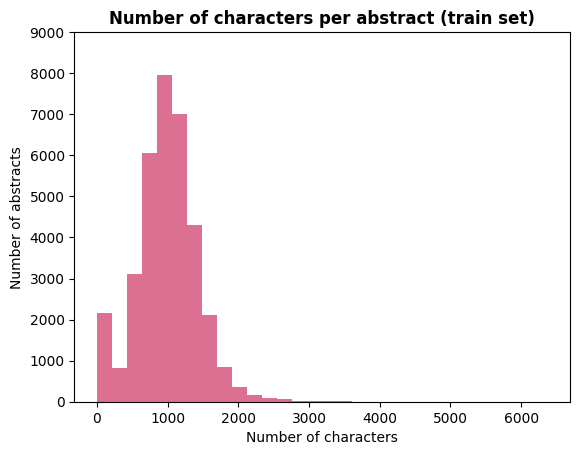

In [ ]:
import matplotlib.pyplot as plt

ax=train_df_tr['train_abstracts'].str.len().hist(color='palevioletred',bins=30)
plt.xlabel('Number of characters')
plt.ylabel('Number of abstracts')
plt.ylim(top=9000)
plt. grid(False)
plt.title('Number of characters per abstract (train set)',fontweight='bold')

As far as the number of words per abstract is concerned, it looks like the most frequent number encountered is around 150.

Text(0.5, 1.0, 'Number of words per abstract (train data)')

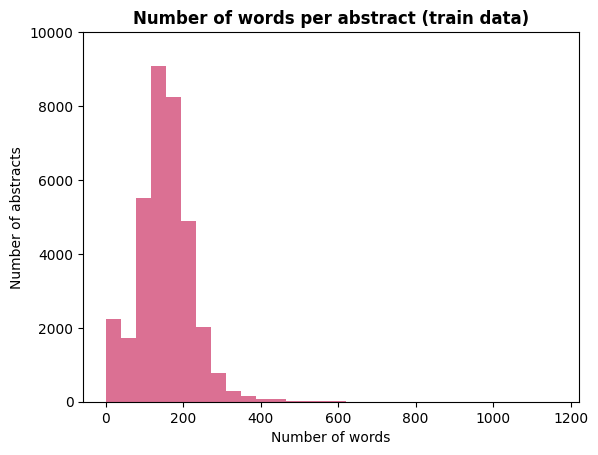

In [ ]:
# Plot
ax=train_df_tr['train_abstracts'].str.split().map(lambda x: len(x)).hist(color='palevioletred',bins=30)
plt.ylim(top=10000)
plt.xlabel('Number of words')
plt.ylabel('Number of abstracts')
plt. grid(False)
plt.title('Number of words per abstract (train data)',fontweight='bold')

Next, we will find out which are the most common words of the train set. As expected, the top 2 words are "data" and "model".

In [ ]:
train_abstracts_lem =train_df_tr['train_abstracts'].apply(lambda text: lemmatize_words(text))

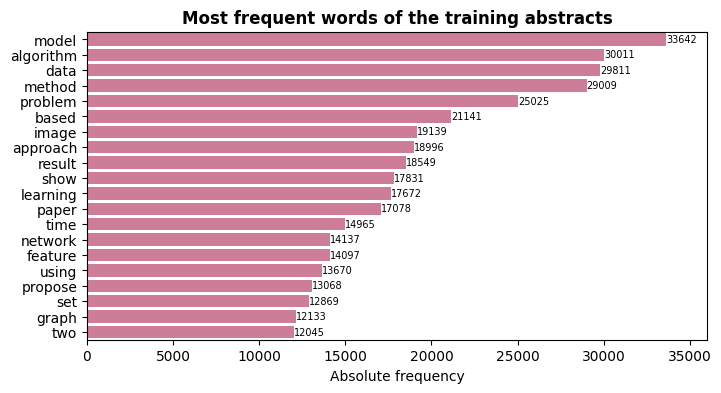

In [ ]:
# Plot of the most frequent words of the training data
fig,ax = plt.subplots(figsize=(8,4))
plot_top_non_stopwords_barchart(train_abstracts_lem,'palevioletred')
_ = ax.set_title('Most frequent words of the training abstracts',fontweight='bold')
_ = ax.set_xlabel('Absolute frequency')
_ = ax.set_xlim(0,36000)
ax.bar_label(ax.containers[0],size=7)
plt.box('False')
plt.savefig('EDA_1.png')

Let's check if there any imbalances on our data. We observe that we don't have the same number of instances per class label.

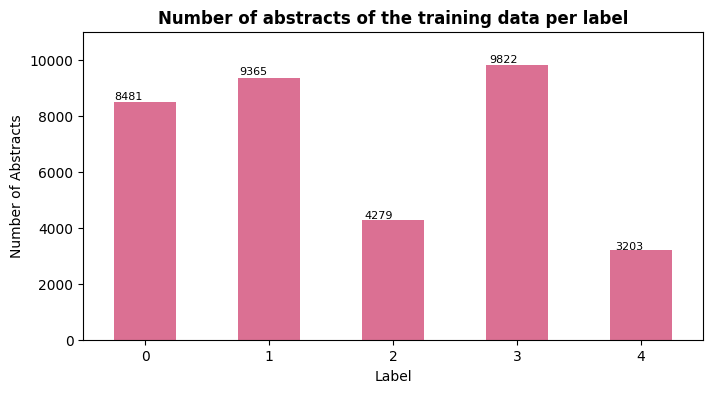

In [ ]:
ax=train_df_tr['label'].astype(int).value_counts().sort_index().plot(kind='bar',color=['palevioletred'], figsize=(8,4))
plt.title('Number of abstracts of the training data per label',fontweight='bold')
plt.ylabel('Number of Abstracts')
plt.xlabel('Label')
plt.ylim(top=11000)
plt.xticks(rotation=0)
#adding the bar labels
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.010, p.get_height() * 1.010),size=8)
plt.savefig("EDA_2.png")
plt.show()

Now we will create another barplot to discover the top 5 authors that are mentioned more often. The most frequent one is Philip S. Yu.

In [ ]:
#getting the frequency of each author's name
auths_value_counts=Counter(flat(train_df_tr['authors'].apply(lambda x: x.split(","))))
#let's locate the most frequent names
num_of_abstr_per_auth=dict(sorted(auths_value_counts.items(), key=lambda x:x[1],reverse=True)[:5])

Text(0.5, 0, 'Number of abstracts')

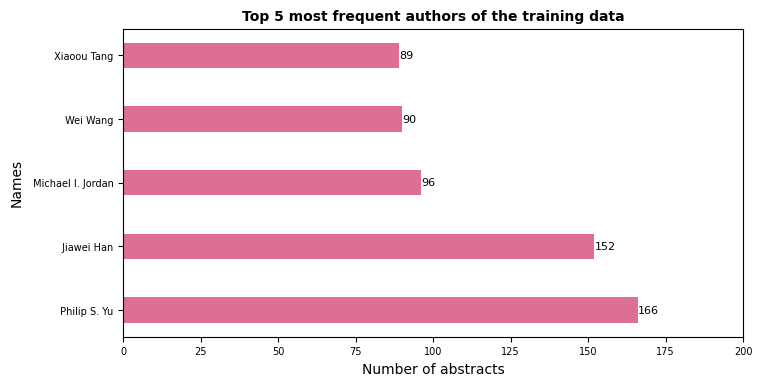

In [ ]:
names = list(num_of_abstr_per_auth.keys())
values = list(num_of_abstr_per_auth.values())
fig,ax = plt.subplots(figsize=(8,4))
ax.barh(range(len(num_of_abstr_per_auth)), values, tick_label=names,color=['palevioletred'],height=0.4,align='center')
ax.bar_label(ax.containers[0],size=8)
plt.title('Top 5 most frequent authors of the training data',fontweight='bold',size=10)
plt.xticks(size=7)
plt.yticks(size=7)
plt.xlim(right=200)
plt.ylabel('Names')
plt.xlabel('Number of abstracts')

### **Test data:**
Below you may find some statistics and plots regarding the test set.

As one can notice, the average document legth is 973 characters with a standard deviation of 434. The minimum legth is 0 (we have some blanks) and the maximum legth is 3088.

In [ ]:
docs_test_len=[]
print('Test data:')
statistics(test_df_tr,'test_abstracts',docs_test_len)

Test data:
The average document length is: 973 (characters). 
The standard deviation of document legth is: 434 (characters). 
The minimum document legth is: 0 (characters). 
The maximum document legth is: 3088 (characters).


Fro the histogram below we observe that the most frequent number of characters per abstract of the test set is around 1000. It is important to mention that the test set includes a fair amount of blanks as  almost 300 abstracts do not contain any text. This is around 7.5% of our test set.

Text(0.5, 1.0, 'Number of characters per abstract (test set)')

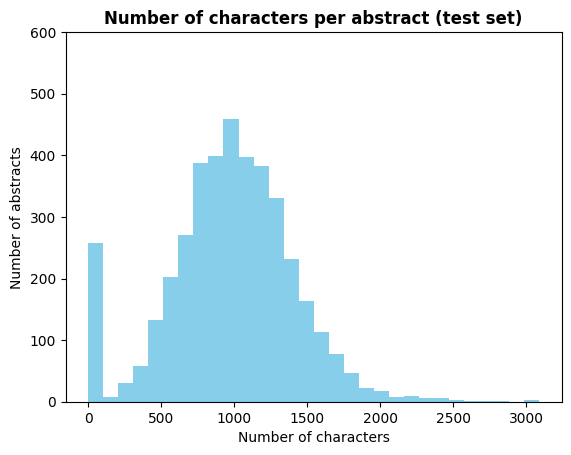

In [ ]:
ax=test_df_tr['test_abstracts'].str.len().hist(color='skyblue',bins=30)
plt.xlabel('Number of characters')
plt.ylabel('Number of abstracts')
plt.ylim(top=600)
plt. grid(False)
plt.title('Number of characters per abstract (test set)',fontweight='bold')

The most frequent number of words per abstract of the test set according to the following plot is around 150.

Text(0.5, 1.0, 'Number of words per abstract (train data)')

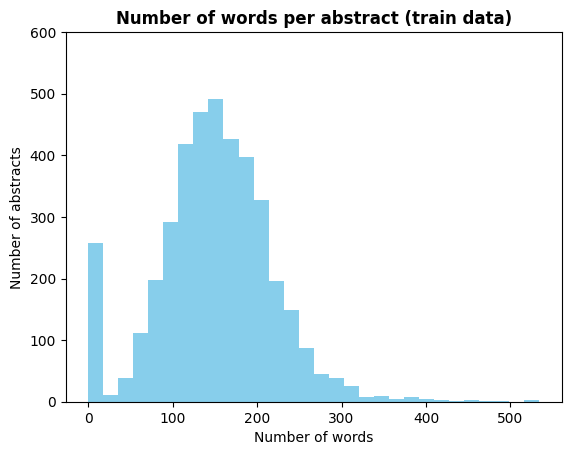

In [ ]:
ax=test_df_tr['test_abstracts'].str.split().map(lambda x: len(x)).hist(color='skyblue',bins=30)
plt.ylim(top=600)
plt.xlabel('Number of words')
plt.ylabel('Number of abstracts')
plt. grid(False)
plt.title('Number of words per abstract (train data)',fontweight='bold')

Again, we observe that the 2 most common words are "model" and "data".

In [ ]:
test_abstracts_lem =test_df_tr['test_abstracts'].apply(lambda text: lemmatize_words(text))

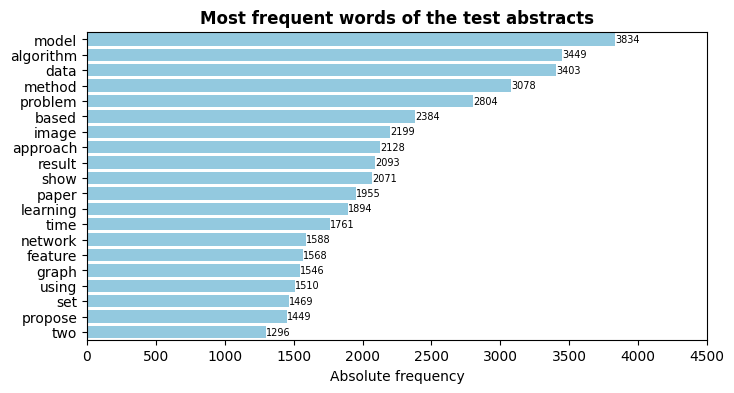

In [ ]:
# Plot of the most frequent words of the training data
fig,ax = plt.subplots(figsize=(8,4))
plot_top_non_stopwords_barchart(test_abstracts_lem,'skyblue')
_ = ax.set_title('Most frequent words of the test abstracts',fontweight='bold')
_ = ax.set_xlabel('Absolute frequency')
_ = ax.set_xlim(0,4500)
ax.bar_label(ax.containers[0],size=7)
plt.box('False')
plt.savefig('EDA_3.png')

Below, we can see that the author that has written the most papers (abstracts) in the test set is again Philip S. Yu.

In [ ]:
#getting the frequency of each author's name
auths_value_counts=Counter(flat(test_df_tr['authors'].apply(lambda x: x.split(","))))
#let's locate the most frequent names
num_of_abstr_per_auth=dict(sorted(auths_value_counts.items(), key=lambda x:x[1],reverse=True)[:5])

Text(0.5, 0, 'Number of abstracts')

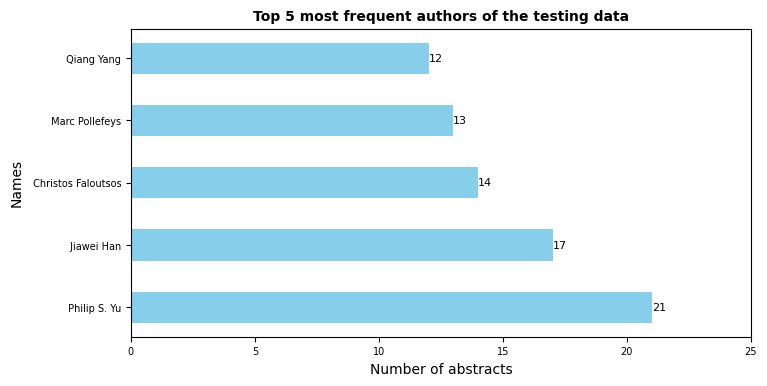

In [ ]:
names = list(num_of_abstr_per_auth.keys())
values = list(num_of_abstr_per_auth.values())
fig,ax = plt.subplots(figsize=(8,4))
ax.barh(range(len(num_of_abstr_per_auth)), values, tick_label=names,color=['skyblue'],height=0.5,align='center')
ax.bar_label(ax.containers[0],size=8)
plt.title('Top 5 most frequent authors of the testing data',fontweight='bold',size=10)
plt.xticks(size=7)
plt.yticks(size=7)
plt.xlim(right=25)
plt.ylabel('Names')
plt.xlabel('Number of abstracts')

##Tokenization

Now we will tokenize the sets we created above, remove any stopwords and filter out tokens that contain certain characters such as newline characters or punctuation marks. Then, we will join the tokenized sentences back together.

In [ ]:
import spacy
import string
from tqdm import tqdm

nlp = spacy.load('en_core_web_sm', disable=["tagger", "parser","ner"])
from spacy.lang.en.stop_words import STOP_WORDS
nlp.add_pipe('sentencizer')

def tokenization(list,X_set):
  for idx in tqdm(range(len(X_set))):
    doc = nlp(X_set[idx])
    tokens = []
    for sent in doc.sents:
      for tok in sent:
        if '\n' in tok.text or "\t" in tok.text or "--" in tok.text or "*" in tok.text or\
        tok.text.lower() in STOP_WORDS or tok.text in string.punctuation:
          continue
        if tok.text.strip():
          tokens.append(tok.text.replace('"',"'").strip())
    list.append(tokens)
  return


In [ ]:
tok_train=[]
tokenization(tok_train,train_df_tr.train_abstracts_all_info)
tok_test=[]
tokenization(tok_test,test_df_tr.test_abstracts_all_info)

  0%|          | 0/35150 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)
100%|██████████| 4023/4023 [00:33<00:00, 121.80it/s]


In [ ]:
docs1=[]
for sentence in tok_train:
  docs1.append(' '.join(sentence))
docs2=[]
for sentence in tok_test:
  docs2.append(' '.join(sentence))

## TF-IDF

First, before implementing any models we need to make some embeddings since our data is textual. In order to create the embeddings we will use [TF-IDF ](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html). We choosed to keep 5000 features at maximum using both unigrams and bigrams as features.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
# Use unigram & bigram tf*idf features
vectorizer = TfidfVectorizer(
    ngram_range=(1, 2),
    max_features=5000,
    sublinear_tf=True,
    stop_words=stopwords.words('english'))

# Fit the Vectorizer
train_tfidf = vectorizer.fit_transform(docs1 )
test_tfidf = vectorizer.transform(docs2)

##Logistic Regression & tfidf (0.40713)

The first model that we implement is Logistic Regression.

In [ ]:
%%capture
!pip install scikit-optimize

We perform hyperparameter tuning using [BayesSearchCV](https://scikit-optimize.github.io/stable/modules/generated/skopt.BayesSearchCV.html) with 5 folds cross-validation to get the best score from the [Logistic Regression ](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html). The aim is to get the lowest possible log loss.

In [ ]:
from sklearn.linear_model import LogisticRegression
from skopt import BayesSearchCV
from joblib import parallel_backend

grid_params = {
    'solver': ['lbfgs','liblinear','newton-cg','sag','saga'],
    'C': [0.01,0.1,0.5,1,5,10]}

clf_reg = BayesSearchCV(LogisticRegression(max_iter=5000), grid_params, scoring = 'neg_log_loss',n_iter=15, cv = 5, verbose = 10, n_jobs=-1,refit=True)
with parallel_backend('multiprocessing'):
  clf_reg.fit(train_tfidf, train_df_tr.label)


[CV 1/5; 1/1] START C=5.0, solver=liblinear.....................................[CV 2/5; 1/1] START C=5.0, solver=liblinear.....................................

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5; 1/1] END .....C=5.0, solver=liblinear;, score=-0.392 total time=   9.6s[CV 2/5; 1/1] END .....C=5.0, solver=liblinear;, score=-0.398 total time=   9.6s

[CV 4/5; 1/1] START C=5.0, solver=liblinear.....................................[CV 3/5; 1/1] START C=5.0, solver=liblinear.....................................

[CV 4/5; 1/1] END .....C=5.0, solver=liblinear;, score=-0.373 total time=   9.3s
[CV 5/5; 1/1] START C=5.0, solver=liblinear.....................................
[CV 3/5; 1/1] END .....C=5.0, solver=liblinear;, score=-0.375 total time=   9.4s
[CV 5/5; 1/1] END .....C=5.0, solver=liblinear;, score=-0.374 total time=   6.2s
[CV 1/5; 1/1] START C=1.0, solver=newton-cg.....................................
[CV 2/5; 1/1] START C=1.0, solver=newton-cg.......

/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


[CV 1/5; 1/1] START C=5.0, solver=lbfgs.........................................
[CV 2/5; 1/1] START C=5.0, solver=lbfgs.........................................
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5; 1/1] END .........C=5.0, solver=lbfgs;, score=-0.390 total time=  53.7s
[CV 3/5; 1/1] START C=5.0, solver=lbfgs.........................................
[CV 2/5; 1/1] END .........C=5.0, solver=lbfgs;, score=-0.399 total time=  55.3s
[CV 4/5; 1/1] START C=5.0, solver=lbfgs.........................................
[CV 4/5; 1/1] END .........C=5.0, solver=lbfgs;, score=-0.371 total time=  56.8s
[CV 5/5; 1/1] START C=5.0, solver=lbfgs.........................................
[CV 3/5; 1/1] END .........C=5.0, solver=lbfgs;, score=-0.374 total time= 1.0min
[CV 5/5; 1/1] END .........C=5.0, solver=lbfgs;, score=-0.371 total time=  31.4s


The hyperparameters that give the lowest log loss are C=1 and solver : lbfgs

In [ ]:
clf_reg.best_params_

OrderedDict([('C', 5.0), ('solver', 'lbfgs')])

Let's now get the best hyperparameters and fit the data to a new model that uses them. Then, we make a prediction. Note: we predict the probabilities that a particular data point falls into the underlying classes. This is the case for all models.

In [ ]:
lr=LogisticRegression(max_iter=5000)
lr.set_params(**clf_reg.best_params_)
lr.fit(train_tfidf,train_df_tr.label)
y_pred=lr.predict_proba(test_tfidf)

##Multinomial Naive Bayes & TF-IDF (0.48695)

Now we will implement a [Multinomial Naive Bayes](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html) model. First we will perform hyperparameter tuning using [BayesSearchCV](https://scikit-optimize.github.io/stable/modules/generated/skopt.BayesSearchCV.html).

In [ ]:
%%capture
from sklearn.naive_bayes import MultinomialNB
from skopt import BayesSearchCV

model = MultinomialNB()
search_space = {'alpha': [1e-10, 1e-8, 1e-5, 1e-3, 1e-2, 1e-1]}
bayes_search = BayesSearchCV(model, search_space, n_iter=15, cv=3,scoring = 'neg_log_loss',n_jobs=1,n_points=3)
bayes_search.fit(train_tfidf.toarray(), train_df_tr.label)

In [ ]:
print("Best yperparameters: ", bayes_search.best_params_)
print("Best Score: ", bayes_search.best_score_)

Best yperparameters:  OrderedDict([('alpha', 0.01)])
Best Score:  -0.45001052623399357


In [ ]:
mnb=MultinomialNB()
mnb.set_params(**bayes_search.best_params_)
mnb.fit(train_tfidf,train_df_tr.label)
y_pred=mnb.predict_proba(test_tfidf)

## Train-Test-Val Split

Now we are ready to split the data and proceed to implementing some models (the fun part). We choose to split the original training set into training and validation. For validation we kept 15% of the original training data. The variables train_abstracts_all_info (from train_df_tr), test_abstracts_all_info (from test_df_tr) include the abstracts, the authors and the years all concatenated to one cell.

In [ ]:
from sklearn.model_selection import train_test_split
X_train_text, X_val_text, y_train_text, y_val_text = train_test_split(train_df_tr.train_abstracts_all_info, train_df_tr.label,
                                                  test_size=0.15, random_state=12)
X_test_text=test_df_tr.test_abstracts_all_info

In [ ]:
X_train_text=X_train_text.tolist()
X_val_text= X_val_text.tolist()
y_train_text=y_train_text.tolist()
y_val_text=y_val_text.tolist()

In [ ]:
print('length of X_train:',len(X_train_text), '\nlength of X_val:', len(X_val_text),'\nlength of y_train:', len(y_train_text),'\nlength of y_val:',len(y_val_text),'\nlength of X_test:', len(X_test_text))

length of X_train: 29877 
length of X_val: 5273 
length of y_train: 29877 
length of y_val: 5273 
length of X_test: 4023


## RNN (bidirectional GRU with self-attention) & fasttext (0.39972)

In [ ]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [ ]:
%%capture
!pip install -U tensorflow
!pip install -U tensorflow-gpu
!pip install -U tensorflow-addons
!pip install -U keras-tuner
import tensorflow as tf
import tensorflow_addons as tfa
import keras_tuner as kt

In [ ]:
X_train_tokenized = []
X_val_tokenized = []
X_test_tokenized = []
tokenization(X_train_tokenized,X_train_text)
tokenization(X_val_tokenized,X_val_text)
tokenization(X_test_tokenized,X_test_text)

docs_train = []
docs_test = []
docs_val = []

for sentence in X_train_tokenized:
  docs_train.append(' '.join(sentence))
for sentence in X_test_tokenized:
  docs_test.append(' '.join(sentence))
for sentence in X_val_tokenized:
  docs_val.append(' '.join(sentence))

  0%|          | 0/29877 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)
100%|██████████| 4023/4023 [00:52<00:00, 76.16it/s]


In order to give the model the true labels to perform backpropagation etc, we need to turn them into an 1 hot vector since we have a multiclass classification problem.

In [ ]:
y_train_1_hot = tf.keras.utils.to_categorical(y_train_text, num_classes=5)
y_val_1_hot = tf.keras.utils.to_categorical(y_val_text, num_classes=5)

Next, we prepair the data by tokenizing them and performing padding to ensure that all sequences have the same length.

In [ ]:
MAX_WORDS = 100000
MAX_SEQUENCE_LENGTH = 256
EMBEDDING_DIM = 300
# Keras tokenizer uses \s for separating tokens
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=MAX_WORDS,
                                                  oov_token='UNK')
tokenizer.fit_on_texts([" ".join(x) for x in X_train_tokenized])
train_seqs = tokenizer.texts_to_sequences([" ".join(x) for x in X_train_tokenized])
val_seqs = tokenizer.texts_to_sequences([" ".join(x) for x in X_val_tokenized])
train_data = tf.keras.utils.pad_sequences(train_seqs,
                                          maxlen=MAX_SEQUENCE_LENGTH,
                                          padding='post')
val_data = tf.keras.utils.pad_sequences(val_seqs,
                                        maxlen=MAX_SEQUENCE_LENGTH,
                                        padding='post')
test_seqs = tokenizer.texts_to_sequences([" ".join(x) for x in X_test_tokenized])
test_data = tf.keras.utils.pad_sequences(test_seqs,
                                        maxlen=MAX_SEQUENCE_LENGTH,
                                        padding='post')

In [ ]:
# Create the word index for the tokenizer
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 77680 unique tokens.


Let's now install and load fasttext to make the word embeddings.

In [ ]:
%%capture
!pip install -U fasttext
# Download the fasttext (pre-trained embeddings)
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz
!gunzip -d cc.en.300.bin.gz

In [ ]:
# Load the fasttext
import fasttext
fasttext_model = fasttext.load_model('cc.en.300.bin')

Below we create the embedding matrix and delete fasttext as it is heavy.

In [ ]:
# Create the embeddings matrix
embedding_matrix = np.zeros(shape=((MAX_WORDS + 2), 300))

for key, value in word_index.items():  # or enumerate(vectorizer.get_vocabulary())
  if value <= MAX_WORDS:
    embedding_matrix[value] = fasttext_model.get_word_vector(word=key)

del fasttext_model

Now, we create the Self Attention class and build the model.

In [ ]:
# Create the SelfAttention MLP
class SelfAttention(tf.keras.layers.Layer):
  def __init__(self, mlp_layers, units, dropout_layers = False, dropout_ = 0, return_attention=False, **kwargs):
    super(SelfAttention, self).__init__(**kwargs)
    self.mlp_layers = mlp_layers
    self.mlp_units = units
    self.return_attention = return_attention
    self.dropout_layers = dropout_layers
    self.dropout_ = dropout_
    self.attention_mlp = self.build_mlp()

  def build_mlp(self):
    mlp = tf.keras.Sequential()
    # mlp.add(tf.keras.layers.Flatten())
    for i in range(self.mlp_layers):
      if self.dropout_layers:
        mlp.add(tf.keras.layers.Dense(self.mlp_units,
                                    activation='relu'))
        mlp.add(tf.keras.layers.Dropout(self.dropout_))
      else:
        mlp.add(tf.keras.layers.Dense(self.mlp_units,
                                    activation='relu'))
    mlp.add(tf.keras.layers.Dense(1))
    return mlp

  def call(self, x, mask=None):
    a = self.attention_mlp(x)
    a = tf.squeeze(a, axis=2)
    print(x.shape)
    print(a.shape)

    if mask is not None:
      mask = tf.keras.backend.cast(mask, tf.keras.backend.floatx())
      a -= 100000.0 * (1.0 - mask)
      # a *= tf.keras.backend.cast(mask, tf.keras.backend.floatx())

    a = tf.keras.backend.expand_dims(tf.keras.backend.softmax(a, axis=-1))
    weighted_input = x * a
    result = tf.keras.backend.sum(weighted_input, axis=1)
    print(result.shape)

    if self.return_attention:
      return [result, a]
    return result

In [ ]:
# Build the model
def model_builder(hp):
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Embedding(MAX_WORDS+2,
                                         EMBEDDING_DIM,
                                         weights=[embedding_matrix],
                                         input_length=MAX_SEQUENCE_LENGTH,
                                         mask_zero=True, trainable=False))

  hp_rate1 = hp.Choice('rate', [0.25,0.33,0.5])
  model.add(tf.keras.layers.Dropout(hp_rate1))

  hp_stacked_rnns = hp.Int('layers', min_value = 1, max_value = 3, step = 1)

  for i in range(hp_stacked_rnns):
    model.add(tf.keras.layers.Bidirectional(
        tf.keras.layers.GRU(
            hp.Int('units_'+str(i), min_value = 32, max_value = 512, step = 32),
            activation = 'tanh',
            recurrent_activation='sigmoid',
            return_sequences = True,
            recurrent_dropout=0,
            use_bias=True,
            unroll=False
        )
    ))

  hp_rate2 = hp.Choice('rate', [0.25,0.33,0.5])
  model.add(tf.keras.layers.Dropout(hp_rate2))

  hp_att_size = hp.Int('mlp_layers', min_value = 1, max_value = 4, step=1)
  hp_att_units = hp.Int('units', min_value = 32, max_value = 320, step = 32)
  model.add(SelfAttention(mlp_layers=hp_att_size, units=hp_att_size))

  hp_denses = hp.Int('units', min_value = 128, max_value = 1024, step = 128)
  model.add(tf.keras.layers.Dense(hp_denses, activation='relu' ))

  hp_rate3 = hp.Choice('rate', [0.25,0.33,0.5])
  model.add(tf.keras.layers.Dropout(hp_rate3))

  model.add(tf.keras.layers.Dense(5,
                                 activation='softmax'))


  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
  model.compile(loss='categorical_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  metrics=["categorical_accuracy"])



  return model

Now we will tune the model aiming to get the lowest validation log loss. We will perform hyperparameter tuning using Bayesian Optimization setting the maximum trials to 10 and patience to 5. We will also add early stopping to make the procedure quicker. Below we can see the search space summary.

In [ ]:
!rm -r untitled_project #if we wish to tune it again this resets the tuner

In [ ]:
tuner = kt.BayesianOptimization(model_builder,objective='val_loss',max_trials=10)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True)
tuner.search_space_summary()

(None, 256, 64)
(None, 256)
(None, 64)
Search space summary
Default search space size: 6
rate (Choice)
{'default': 0.25, 'conditions': [], 'values': [0.25, 0.33, 0.5], 'ordered': True}
layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
mlp_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 4, 'step': 1, 'sampling': 'linear'}
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 320, 'step': 32, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


The hyperparameters to be tuned are :


*   Learning rate
*   Number of attention mlp layers
*   Number of stacked biGRU
*   Number of nodes per layer
*   Dropout rate



In [ ]:
tuner.search(train_data, y_train_1_hot,
              validation_data=(val_data, y_val_1_hot),
              batch_size=64,
              epochs=200,
              shuffle=True,
              callbacks = [early_stopping])
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 10 Complete [00h 08m 04s]
val_loss: 0.38395848870277405

Best val_loss So Far: 0.34822016954421997
Total elapsed time: 01h 54m 42s


In [ ]:
tuner.results_summary() # Summary of the hyperparameters which gave the smallest val losses

Results summary
Results in ./untitled_project
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 08 summary
Hyperparameters:
rate: 0.5
layers: 2
units_0: 352
mlp_layers: 3
units: 288
learning_rate: 0.001
units_1: 352
units_2: 224
Score: 0.34822016954421997

Trial 07 summary
Hyperparameters:
rate: 0.33
layers: 3
units_0: 384
mlp_layers: 2
units: 224
learning_rate: 0.001
units_1: 160
units_2: 512
Score: 0.38122668862342834

Trial 09 summary
Hyperparameters:
rate: 0.25
layers: 1
units_0: 352
mlp_layers: 1
units: 320
learning_rate: 0.001
units_1: 448
units_2: 256
Score: 0.38395848870277405

Trial 02 summary
Hyperparameters:
rate: 0.25
layers: 1
units_0: 64
mlp_layers: 2
units: 160
learning_rate: 0.001
units_1: 32
Score: 0.3928855061531067

Trial 01 summary
Hyperparameters:
rate: 0.25
layers: 1
units_0: 192
mlp_layers: 1
units: 192
learning_rate: 0.01
units_1: 288
Score: 0.42087846994400024

Trial 03 summary
Hyperparameters:
rate: 0.33
layers: 3
units_0: 96
mlp_layers

We now create a class for the metrics. This will print the F1 score, Recall, Precision and Accuracy for the validation set at the end of each epoch.

In [ ]:
class Metrics(tf.keras.callbacks.Callback):
    def __init__(self, valid_data):
        super(Metrics, self).__init__()
        self.validation_data = valid_data

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        val_predict = np.argmax(self.model.predict(self.validation_data[0]), -1)
        val_targ = self.validation_data[1]
        val_targ = tf.cast(val_targ,dtype=tf.float32)
        if len(val_targ.shape) == 2 and val_targ.shape[1] != 1:
          val_targ = np.argmax(val_targ, -1)


        _val_f1 = f1_score(val_targ, val_predict, average='macro')
        _val_recall = recall_score(val_targ,
                                   val_predict, average='macro')
        _val_precision = precision_score(val_targ,
                                         val_predict,average='macro')
        _val_accuracy = accuracy_score(val_targ, val_predict)

        logs['val_f1'] = _val_f1
        logs['val_recall'] = _val_recall
        logs['val_precision'] = _val_precision
        print("val_accuracy: %f — val_f1: %f — val_precision: %f — val_recall: %f" % (_val_accuracy, _val_f1, _val_precision, _val_recall))
        return



In [ ]:
import os
if not os.path.exists('./checkpoints'):
  os.makedirs('./checkpoints')
checkpoint = tf.keras.callbacks.ModelCheckpoint('checkpoints/weights.hdf5',
                                                monitor='val_f1',
                                                mode='max',
                                                verbose=2,
                                                save_best_only=True,
                                                save_weights_only=True)

Let's now fit the model using the best hyperparameters and make a prediction. Again we use early stopping to save time.

In [ ]:
import keras.backend as K
from sklearn.metrics import f1_score, recall_score, precision_score, classification_report, confusion_matrix, precision_recall_curve, auc, accuracy_score
import time

model = tuner.hypermodel.build(best_hps)
print(model.summary())
history = model.fit(train_data, y_train_1_hot, epochs=200, validation_data=(val_data, y_val_1_hot),
                    callbacks=[Metrics(valid_data=(val_data, y_val_1_hot)),
                         checkpoint,
                         tf.keras.callbacks.EarlyStopping( monitor='val_loss', patience=5, restore_best_weights=True)])


(None, 256, 704)
(None, 256)
(None, 704)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 256, 300)          30000600  
                                                                 
 dropout_3 (Dropout)         (None, 256, 300)          0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 256, 704)         1381248   
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 256, 704)         2234496   
 nal)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 256, 704)          0         
                                                                 
 self_attenti

In [ ]:
y_pred = model.predict(test_data)

126/126 [==============================] - 4s 29ms/step


#**2nd Approach - Using Graphs only**
Since the results we got from using text data only weren't satisfactory, we will now try predicting the unknown labels using the graph data. Here, we will use [Word2Vec ](https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html) to create the embeddings. The models to be implemented are:

* Multi-layer Perceptron (MLP)
* MLP ensembling
* Support Vector Machine (SVM)
* SVM ensembling
* Logistic Regression ensembling
* SVM & Logistic Regression ensembling







In this section we create the graphs both for the training and the test dataset.

## Train-Test Graphs

By utilizing the 'edgelist.txt' we create a Digraph. A DiGraph stores nodes and edges with optional data, or attributes. Also, hold directed edges.



Thus, we create a dataframe named train_graphs, which contains the 'in' and 'out' nodes, the core and the clustering.

**Definitions**

1) The in-degree is the number of incoming edges onto a node.

2) The out-degree is the number of outcoming edges onto a node.


In [ ]:
# Create a directed graph
G = nx.read_edgelist("edgelist.txt", nodetype=int, create_using=nx.DiGraph)
print('Number of nodes:', G.number_of_nodes())
print('Number of edges:', G.number_of_edges())

Number of nodes: 166986
Number of edges: 591017


In [ ]:
# Create the training matrix. Each row corresponds to a research paper.
# Use the following 3 features for each paper:
# (1) out-degree of node
# (2) in-degree of node
# (3) average degree of neighborhood of node
clustering = nx.clustering(G)
core_nums = nx.core_number(G.to_undirected())
train_graphs = np.zeros((len(train_papers), 4))

#avg_neig_deg = nx.average_neighbor_degree(G, nodes=train_papers)
for i in range(len(train_papers)):
    train_graphs[i,0] = G.in_degree(train_papers[i])
    train_graphs[i,1] = G.out_degree(train_papers[i])
    train_graphs[i,2] = core_nums[train_papers[i]]
    train_graphs[i,3] = clustering[train_papers[i]]

In [ ]:
train_graphs = pd.DataFrame(train_graphs, columns=['in', 'out', 'core', 'clustering'], index=train_papers)
train_graphs

,in,out,core,clustering
2,7.0,59.0,9.0,0.014918
3,0.0,24.0,10.0,0.012681
6,5.0,15.0,11.0,0.073684
8,1.0,18.0,11.0,0.087719
13,1.0,16.0,4.0,0.003676
...,...,...,...,...
166969,1.0,34.0,12.0,0.015966
166976,0.0,8.0,5.0,0.000000
166977,0.0,6.0,5.0,0.000000
166978,1.0,11.0,8.0,0.015152


Following the previous technique, we construct the test_graphs dataframe.


In [ ]:
test_graphs = np.zeros((len(test_papers), 4))
#avg_neig_deg = nx.average_neighbor_degree(G, nodes=test_papers)
for i in range(len(test_papers)):
    test_graphs[i,0] = G.in_degree(test_papers[i])
    test_graphs[i,1] = G.out_degree(test_papers[i])
    test_graphs[i,2] = core_nums[test_papers[i]]
    test_graphs[i,3] = clustering[test_papers[i]]

In [ ]:
test_graphs = pd.DataFrame(test_graphs, columns=['in', 'out', 'core', 'clustering'], index=test_papers)
test_graphs

,in,out,core,clustering
27,3.0,21.0,14.0,0.043478
49,8.0,23.0,10.0,0.053763
85,0.0,22.0,11.0,0.021645
242,3.0,14.0,9.0,0.044118
383,0.0,19.0,10.0,0.058480
...,...,...,...,...
166707,0.0,1.0,1.0,0.000000
166737,1.0,21.0,11.0,0.058442
166858,0.0,5.0,1.0,0.000000
166926,2.0,10.0,6.0,0.037879


## Random Walk-W2Vec Embeddings

By utilizing the 'random_walk' function, we construct a random walk which starts from vertex 'node' and performs a random walk of length walk length.

In [ ]:
def random_walk(G, node, walk_length):
    """
    Starts from vertex "node" and performs a random walk of length "walk length".
    Returns a list of the visited vertices"""
    walk = [node]

    for i in range(walk_length-1):
      nbrs = list(G.neighbors(walk[-1]))
      next_node = choice(nbrs)
      walk.append(next_node)

    return walk

In [ ]:
def generate_walks(G, num_walks, walk_length):
    # Runs "num_walks" random walks from each node, and returns a list of all random walk
    walks = list()

    for i in range(num_walks):
      for node in G.nodes():
        walk = random_walk(G, node, walk_length)
        walks.append(walk)

    return walks

In [ ]:
walks = generate_walks(G.to_undirected(), num_walks=12, walk_length=10)

Here we construct the word2Vec model with vector size 128 and window 15.

In [ ]:
model_w2v = Word2Vec(sentences=walks, vector_size=128, window=15, min_count=0, epochs=10, workers=6)

Saving W2V :

In [ ]:
'''import pickle
from google.colab import drive
drive.mount('/content/drive')

#saving model_w2v
with open('/content/drive/MyDrive//DS_challenge_final/model_w2v.pickle', 'wb') as f:
   pickle.dump(model_w2v,f,protocol=pickle.HIGHEST_PROTOCOL)'''

"import pickle\nfrom google.colab import drive\ndrive.mount('/content/drive')\n\n#saving model_w2v\nwith open('/content/drive/MyDrive//DS_challenge_final/model_w2v.pickle', 'wb') as f:\n   pickle.dump(model_w2v,f,protocol=pickle.HIGHEST_PROTOCOL)"

In [ ]:
%%capture
# Import W2Vec from dropbox
!wget -O model_w2v.pickle https://www.dropbox.com/s/vtps05waqzwo9y7/model_w2v.pickle?dl=0

In [ ]:
import pickle
with open('model_w2v.pickle', 'rb') as f:
    model_w2v = pickle.load(f)

## Constructing the dataframes (Word2Vec)

In this section we construct the dataframes which contains the word2vec of the generated walks. We create both the word2vec dataframes for the train and test datasets.

In [ ]:
X_train_w2v = np.zeros((len(train_papers), 128))
for i, node in enumerate(train_papers):
  X_train_w2v[i,:] = model_w2v.wv[node]

print('Size of training matrix:', X_train_w2v.shape)

Size of training matrix: (35163, 128)


In [ ]:
# Create the word2vec dataframe for train
df_train_w2v = pd.DataFrame(X_train_w2v)
df_train_w2v

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,-0.826011,-1.559866,-1.031449,-1.303796,0.600275,4.491592,2.316874,2.936785,2.235126,-0.188566,...,3.196782,5.340355,-1.143825,-2.555632,0.373935,1.822167,0.748101,2.772290,-1.641072,2.360087
1,-0.595744,-0.979939,-1.512454,1.115559,-1.109232,-0.595538,-1.325662,0.635484,-2.066242,0.498279,...,0.787389,0.267590,-1.823826,-0.933920,-2.065582,-0.282151,1.286186,-0.714621,-0.468557,-1.759207
2,-0.355154,0.451460,0.460663,-1.089316,-0.477700,-1.542480,0.583610,0.673817,-0.065907,0.310962,...,0.093424,1.292426,0.292666,-0.513240,0.031481,-0.659346,-0.169611,0.601195,-1.340446,1.380776
3,0.097665,-1.451522,0.007340,-0.150016,0.075690,-0.098223,0.225786,0.704549,-0.025167,0.448597,...,0.002553,0.122208,0.352030,-0.400321,0.850391,-0.718179,0.904153,-1.596522,-1.269927,-0.186276
4,0.002150,0.627110,0.782627,-0.917596,0.883707,0.002359,-0.802711,-1.548440,-1.065840,1.025518,...,3.048641,-0.330137,-1.553855,-1.453742,1.536194,-0.938868,-0.144271,0.793619,1.525444,1.362660
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35158,-3.697772,-1.486543,0.412074,1.012237,-0.918355,1.941029,1.133936,1.001746,-1.236107,-0.692076,...,1.944383,1.225858,-0.198087,-2.458675,4.000041,1.533076,2.385074,2.759932,-2.061256,-0.182207
35159,0.979207,-1.590969,0.442346,-0.048746,-0.570112,0.088457,-0.205603,-0.157634,0.173891,-0.394341,...,1.822189,0.452255,-0.966056,0.430412,0.023482,-0.655627,0.857998,-1.114521,-0.559778,-1.517484
35160,-0.101171,-0.842285,-0.173105,0.342372,0.323881,-0.030832,-0.364847,0.153390,0.054119,0.031189,...,0.392105,0.315629,-0.057293,-0.250934,-0.014128,-0.569150,-0.001846,0.404061,-0.564126,0.111615
35161,0.372565,0.122163,-0.911553,0.707087,-0.438458,-0.457006,0.277142,-0.243889,-0.467322,0.711237,...,0.728139,1.098269,-0.889434,-0.447758,-0.814310,-0.217351,0.506384,-1.408371,0.466946,-1.123713


In [ ]:
# Rename the columns
for col in df_train_w2v.columns:
    df_train_w2v.rename(columns = {col: f"w2v_{col}"}, inplace=True)
df_train_w2v

,w2v_0,w2v_1,w2v_2,w2v_3,w2v_4,w2v_5,w2v_6,w2v_7,w2v_8,w2v_9,...,w2v_118,w2v_119,w2v_120,w2v_121,w2v_122,w2v_123,w2v_124,w2v_125,w2v_126,w2v_127
0,-0.826011,-1.559866,-1.031449,-1.303796,0.600275,4.491592,2.316874,2.936785,2.235126,-0.188566,...,3.196782,5.340355,-1.143825,-2.555632,0.373935,1.822167,0.748101,2.772290,-1.641072,2.360087
1,-0.595744,-0.979939,-1.512454,1.115559,-1.109232,-0.595538,-1.325662,0.635484,-2.066242,0.498279,...,0.787389,0.267590,-1.823826,-0.933920,-2.065582,-0.282151,1.286186,-0.714621,-0.468557,-1.759207
2,-0.355154,0.451460,0.460663,-1.089316,-0.477700,-1.542480,0.583610,0.673817,-0.065907,0.310962,...,0.093424,1.292426,0.292666,-0.513240,0.031481,-0.659346,-0.169611,0.601195,-1.340446,1.380776
3,0.097665,-1.451522,0.007340,-0.150016,0.075690,-0.098223,0.225786,0.704549,-0.025167,0.448597,...,0.002553,0.122208,0.352030,-0.400321,0.850391,-0.718179,0.904153,-1.596522,-1.269927,-0.186276
4,0.002150,0.627110,0.782627,-0.917596,0.883707,0.002359,-0.802711,-1.548440,-1.065840,1.025518,...,3.048641,-0.330137,-1.553855,-1.453742,1.536194,-0.938868,-0.144271,0.793619,1.525444,1.362660
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35158,-3.697772,-1.486543,0.412074,1.012237,-0.918355,1.941029,1.133936,1.001746,-1.236107,-0.692076,...,1.944383,1.225858,-0.198087,-2.458675,4.000041,1.533076,2.385074,2.759932,-2.061256,-0.182207
35159,0.979207,-1.590969,0.442346,-0.048746,-0.570112,0.088457,-0.205603,-0.157634,0.173891,-0.394341,...,1.822189,0.452255,-0.966056,0.430412,0.023482,-0.655627,0.857998,-1.114521,-0.559778,-1.517484
35160,-0.101171,-0.842285,-0.173105,0.342372,0.323881,-0.030832,-0.364847,0.153390,0.054119,0.031189,...,0.392105,0.315629,-0.057293,-0.250934,-0.014128,-0.569150,-0.001846,0.404061,-0.564126,0.111615
35161,0.372565,0.122163,-0.911553,0.707087,-0.438458,-0.457006,0.277142,-0.243889,-0.467322,0.711237,...,0.728139,1.098269,-0.889434,-0.447758,-0.814310,-0.217351,0.506384,-1.408371,0.466946,-1.123713


In [ ]:
X_test_w2v = np.zeros((len(test_papers), 128))
for i, node in enumerate(test_papers):
  X_test_w2v[i,:] = model_w2v.wv[node]

print('Size of test matrix:', X_test_w2v.shape)

Size of test matrix: (4023, 128)


In [ ]:
# Create the word2vec dataframe for test
df_test_w2v = pd.DataFrame(X_test_w2v)
df_test_w2v

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,-0.474143,-0.144806,-0.009066,-0.680633,-0.276263,0.686233,-0.460406,0.228191,0.550721,-0.086504,...,0.088566,0.156756,-0.378278,0.152512,-0.700845,-0.823168,1.015888,-0.745858,-0.901118,1.494601
1,0.787070,1.301496,0.452037,1.509173,-0.311583,-1.346161,-0.965696,-0.580667,-0.422946,-0.618541,...,0.606190,1.246183,-0.257418,-0.841943,-0.299343,0.853620,0.548748,-0.158492,-0.890754,0.577576
2,-1.200619,-2.029063,-2.117481,-0.222670,-0.356393,0.233501,0.997867,0.636486,0.289252,1.253936,...,0.762206,-1.154112,0.348480,0.015353,1.102408,0.220731,1.426279,0.397358,-0.752980,1.594206
3,0.070409,-2.321657,0.176784,0.048981,1.301973,0.411529,-0.643762,-0.995386,0.816683,-0.124218,...,-0.100815,0.415179,1.076239,0.179446,0.360870,0.518949,0.057691,-0.688471,0.857722,-0.014727
4,-0.149791,0.272625,-0.830142,-0.021916,-0.065913,0.792115,-0.182138,-0.354671,-0.213011,0.229308,...,0.170916,-0.013557,-0.550978,0.714268,-0.778305,-0.739155,-0.258019,-0.810986,1.374135,0.224316
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4018,0.140205,-0.502311,0.060959,0.238423,0.216492,-0.099370,0.104141,0.002018,0.013598,0.000247,...,0.408683,0.366207,-0.155087,-0.259909,0.108421,-0.115071,0.047056,-0.065633,-0.188548,0.327029
4019,-0.807975,-0.362235,0.705945,0.739034,0.354401,1.964672,0.246621,-0.826726,-0.311298,0.341025,...,-0.099143,0.638152,0.027710,-0.502032,2.243464,-0.683835,1.405858,-0.948501,-0.129586,1.891461
4020,-0.623159,-2.273998,0.395067,-1.194203,-0.194112,-0.298396,0.861295,0.243959,-0.644940,-0.530076,...,1.338836,0.988553,-0.671810,-1.734280,0.562687,-0.067276,0.475396,0.729401,-1.056400,2.477640
4021,-0.363402,0.094704,-0.515017,0.014399,0.930288,-0.203883,0.541129,-0.017299,0.312127,0.874646,...,0.139461,-1.464018,-0.625580,0.175723,-1.324437,0.562686,-0.495344,0.779011,0.792481,-0.007517


In [ ]:
# Rename the columns
for col in df_test_w2v.columns:
    df_test_w2v.rename(columns = {col: f"w2v_{col}"}, inplace=True)
df_test_w2v

,w2v_0,w2v_1,w2v_2,w2v_3,w2v_4,w2v_5,w2v_6,w2v_7,w2v_8,w2v_9,...,w2v_118,w2v_119,w2v_120,w2v_121,w2v_122,w2v_123,w2v_124,w2v_125,w2v_126,w2v_127
0,-0.474143,-0.144806,-0.009066,-0.680633,-0.276263,0.686233,-0.460406,0.228191,0.550721,-0.086504,...,0.088566,0.156756,-0.378278,0.152512,-0.700845,-0.823168,1.015888,-0.745858,-0.901118,1.494601
1,0.787070,1.301496,0.452037,1.509173,-0.311583,-1.346161,-0.965696,-0.580667,-0.422946,-0.618541,...,0.606190,1.246183,-0.257418,-0.841943,-0.299343,0.853620,0.548748,-0.158492,-0.890754,0.577576
2,-1.200619,-2.029063,-2.117481,-0.222670,-0.356393,0.233501,0.997867,0.636486,0.289252,1.253936,...,0.762206,-1.154112,0.348480,0.015353,1.102408,0.220731,1.426279,0.397358,-0.752980,1.594206
3,0.070409,-2.321657,0.176784,0.048981,1.301973,0.411529,-0.643762,-0.995386,0.816683,-0.124218,...,-0.100815,0.415179,1.076239,0.179446,0.360870,0.518949,0.057691,-0.688471,0.857722,-0.014727
4,-0.149791,0.272625,-0.830142,-0.021916,-0.065913,0.792115,-0.182138,-0.354671,-0.213011,0.229308,...,0.170916,-0.013557,-0.550978,0.714268,-0.778305,-0.739155,-0.258019,-0.810986,1.374135,0.224316
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4018,0.140205,-0.502311,0.060959,0.238423,0.216492,-0.099370,0.104141,0.002018,0.013598,0.000247,...,0.408683,0.366207,-0.155087,-0.259909,0.108421,-0.115071,0.047056,-0.065633,-0.188548,0.327029
4019,-0.807975,-0.362235,0.705945,0.739034,0.354401,1.964672,0.246621,-0.826726,-0.311298,0.341025,...,-0.099143,0.638152,0.027710,-0.502032,2.243464,-0.683835,1.405858,-0.948501,-0.129586,1.891461
4020,-0.623159,-2.273998,0.395067,-1.194203,-0.194112,-0.298396,0.861295,0.243959,-0.644940,-0.530076,...,1.338836,0.988553,-0.671810,-1.734280,0.562687,-0.067276,0.475396,0.729401,-1.056400,2.477640
4021,-0.363402,0.094704,-0.515017,0.014399,0.930288,-0.203883,0.541129,-0.017299,0.312127,0.874646,...,0.139461,-1.464018,-0.625580,0.175723,-1.324437,0.562686,-0.495344,0.779011,0.792481,-0.007517


## Train-Test-Val Split

Now will split the data utilizing 15% of the training set for validation.

In [ ]:
X_train_graphs, X_val_graphs, y_train_graphs, y_val_graphs = train_test_split(df_train_w2v, y_train,
                                                  test_size=0.15,
                                                  random_state=12)
X_test_graphs=df_test_w2v

##MLP(0.34573)

In [ ]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

The class below is the same we used above (RNN) but we put it here again in case we do not wish to run the whole notebook.

In [ ]:
class Metrics(tf.keras.callbacks.Callback):
    def __init__(self, valid_data):
        super(Metrics, self).__init__()
        self.validation_data = valid_data

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        val_predict = np.argmax(self.model.predict(self.validation_data[0]), -1)
        val_targ = self.validation_data[1]
        val_targ = tf.cast(val_targ,dtype=tf.float32)
        if len(val_targ.shape) == 2 and val_targ.shape[1] != 1:
          val_targ = np.argmax(val_targ, -1)


        _val_f1 = f1_score(val_targ, val_predict, average='macro')
        _val_recall = recall_score(val_targ,
                                   val_predict, average='macro')
        _val_precision = precision_score(val_targ,
                                         val_predict,average='macro')
        _val_accuracy = accuracy_score(val_targ, val_predict)

        logs['val_f1'] = _val_f1
        logs['val_recall'] = _val_recall
        logs['val_precision'] = _val_precision
        print("val_accuracy: %f — val_f1: %f — val_precision: %f — val_recall: %f" % (_val_accuracy, _val_f1, _val_precision, _val_recall))
        return



In [ ]:
%%capture
!pip install -U tensorflow
!pip install -U tensorflow-gpu
!pip install -U tensorflow-addons
!pip install -U keras-tuner
import tensorflow as tf
import tensorflow_addons as tfa
import keras_tuner as kt

Turning the true labels to 1 hot vectors since our classification task is multiclass.

In [ ]:
y_train_1_hot = tf.keras.utils.to_categorical(y_train_graphs, num_classes=5)
y_val_1_hot = tf.keras.utils.to_categorical(y_val_graphs, num_classes=5)

Now we build the model. Our model has an input layer with swish as activation function, 1 hidden layer with swish as activation function and an output layer with softmax as activation function since our task is multiclass classification. The optimizer that we choose is Adam.

In [ ]:
def model_builder1(hp):

  model = tf.keras.Sequential()

  # Hyperparameters
  hp_units = hp.Int('units', min_value=32, max_value=512, step=10)
  hp_units2 = hp.Int('units2', min_value=32, max_value=512, step=10)
  hp_rate1 = hp.Choice('rate', [0.25,0.33,0.5])
  hp_rate2 = hp.Choice('rate2', [0.25,0.33,0.5])

  #hidden layers
  model.add(tf.keras.layers.Dense(units=hp_units,input_dim=X_train_graphs.shape[1], activation='swish'))
  model.add(tf.keras.layers.Dropout(hp_rate1))
  model.add(tf.keras.layers.Dense(units=hp_units2, activation='swish'))
  model.add(tf.keras.layers.Dropout(hp_rate2))

  #output layer
  model.add(tf.keras.layers.Dense(5, activation='softmax'))

  model.compile(optimizer=tf.keras.optimizers.Adam(),loss='categorical_crossentropy',metrics=[tf.keras.metrics.CategoricalAccuracy()])

  return model


In [ ]:
!rm -r untitled_project #if we wish to tune it again this resets the tuner

In order to perform hyperparameter tuning, we implement Bayesian Optimization. We tune the model for:


*   Learning rate (the optimizer chooses the values freely)
*   Number of neurons (nodes) per layer
*   Dropout rate

The lowest validation loss that we reached during tuning is around 0.3073

In [ ]:
tuner1 = kt.BayesianOptimization(model_builder1,objective='val_loss',max_trials=50)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True)
tuner1.search_space_summary()

tuner1.search(X_train_graphs, y_train_1_hot,
              validation_data=(X_val_graphs, y_val_1_hot),
              batch_size= 256,
              epochs=500,
              shuffle=True,
              callbacks = [early_stopping])
best_hps=tuner1.get_best_hyperparameters(num_trials=1)[0]

Trial 50 Complete [00h 00m 18s]
val_loss: 0.32410508394241333

Best val_loss So Far: 0.3072679340839386
Total elapsed time: 00h 15m 50s


In [ ]:
import os
if not os.path.exists('./checkpoints'):
  os.makedirs('./checkpoints')
checkpoint = tf.keras.callbacks.ModelCheckpoint('checkpoints/weights.hdf5',
                                                monitor='val_f1',
                                                mode='max',
                                                verbose=2,
                                                save_best_only=True,
                                                save_weights_only=True)

Let's now train the model using the best hyperparameters that we got from tuning. We are using again early stopping to save time. Finally, we make a prediction.

In [ ]:
import keras.backend as K
from sklearn.metrics import f1_score, recall_score, precision_score, classification_report, confusion_matrix, precision_recall_curve, auc, accuracy_score
import time
import numpy as np

st = time.time()
model = tuner1.hypermodel.build(best_hps)
print(model.summary())
history = model.fit(X_train_graphs, y_train_1_hot, epochs=500, validation_data=(X_val_graphs, y_val_1_hot),
                    callbacks=[Metrics(valid_data=(X_val_graphs, y_val_1_hot)),
                    checkpoint,tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)])


et = time.time()
elapsed_time = et - st
y_pred = model.predict(X_test_graphs)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 322)               32522     
                                                                 
 dropout_2 (Dropout)         (None, 322)               0         
                                                                 
 dense_4 (Dense)             (None, 182)               58786     
                                                                 
 dropout_3 (Dropout)         (None, 182)               0         
                                                                 
 dense_5 (Dense)             (None, 5)                 915       
                                                                 
Total params: 92,223
Trainable params: 92,223
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/500
165/165 [========================

##MLP ensembling (0.30241)

If one model is able to perform that well, let's see what happens if we take 5 copies of it (with best hps) and train a meta-learner that will combine the predictions from the 5 copies.

In [ ]:
from sklearn.metrics import f1_score, recall_score, accuracy_score,precision_score
# train models and keep them to file
n_members = 5
for i in range(n_members):
  # define and fit model
  model = tuner1.hypermodel.build(best_hps)
  model.fit(X_train_graphs, y_train_1_hot, epochs=500, validation_data=(X_val_graphs, y_val_1_hot),
                  callbacks=[Metrics(valid_data=(X_val_graphs, y_val_1_hot)),
                      checkpoint,tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)])
    # save model to file
  filename = 'model_' + str(i + 1) + '.h5'
  model.save(filename)
  print('Saved: %s' % filename)

Epoch 1/500
165/165 [==============================] - 0s 1ms/step
val_accuracy: 0.869573 — val_f1: 0.875386 — val_precision: 0.868886 — val_recall: 0.884943

Epoch 1: val_f1 did not improve from 0.89535
934/934 [==============================] - 6s 5ms/step - loss: 0.4779 - categorical_accuracy: 0.8347 - val_loss: 0.3527 - val_categorical_accuracy: 0.8696 - val_f1: 0.8754 - val_recall: 0.8849 - val_precision: 0.8689
Epoch 2/500
165/165 [==============================] - 0s 2ms/step
val_accuracy: 0.877915 — val_f1: 0.884646 — val_precision: 0.881268 — val_recall: 0.890307

Epoch 2: val_f1 did not improve from 0.89535
934/934 [==============================] - 4s 4ms/step - loss: 0.3859 - categorical_accuracy: 0.8600 - val_loss: 0.3385 - val_categorical_accuracy: 0.8779 - val_f1: 0.8846 - val_recall: 0.8903 - val_precision: 0.8813
Epoch 3/500
165/165 [==============================] - 0s 1ms/step
val_accuracy: 0.880000 — val_f1: 0.887845 — val_precision: 0.885919 — val_recall: 0.891455


Here we load the models we have previously saved and stack them into a list:

In [ ]:
from keras.models import load_model
# load pre-trained ensemble members
n_members = 5
models = list()
for i in range(n_members):
  # load model
  filename = 'model_' + str(i + 1) + '.h5'
  model = load_model(filename)
  # store in memory
  models.append(model)

Here we perform the ensembling. We take the average of the outputs of each mlp and then we build a model that takes the same input as the 5 copies and produces the average of their outputs as output.

In [ ]:
def ensembleModels(models, model_input):
    # collect outputs of models in a list
    yModels=[model(model_input) for model in models]     # averaging outputs
    yAvg=tf.keras.layers.average(yModels)     # build model from same input and avg output
    modelEns = tf.keras.Model(inputs=model_input, outputs=yAvg, name='ensemble')

    return modelEns

In [ ]:
model_input = tf.keras.Input(shape=models[0].input_shape[1:]) # c*h*w
modelEns = ensembleModels(models, model_input)
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 322)               32522     
                                                                 
 dropout_12 (Dropout)        (None, 322)               0         
                                                                 
 dense_19 (Dense)            (None, 182)               58786     
                                                                 
 dropout_13 (Dropout)        (None, 182)               0         
                                                                 
 dense_20 (Dense)            (None, 5)                 915       
                                                                 
Total params: 92,223
Trainable params: 92,223
Non-trainable params: 0
_________________________________________________________________


Finally, we save the ensembling model, load it and make the prediction.

In [ ]:
# save model to file
filename = 'ensembling_1' + '.h5'
model.save(filename)
print('Saved: %s' % filename)

Saved: ensembling_1.h5


In [ ]:
from keras.models import load_model
# load pre-trained ensemble members
filename = 'ensembling_1' + '.h5'
model = load_model(filename)
# store in memory
models.append(model)
#make a prrediction
y_pred=modelEns.predict(X_test_graphs)

126/126 [==============================] - 0s 2ms/step


## Ensempling Logistic Regression (0.40319)

Let's now try to ensemble logistic regression. First we will tune the model to get the C and the solver that gives the lowest log loss and then we will make 4 copies of it. Again, in order to perform the tuning we use randomized search with 5 folds cross-validation.

In [ ]:
%%capture
!pip install scikit-optimize

In [ ]:
from sklearn.linear_model import LogisticRegression
from skopt import BayesSearchCV
from joblib import parallel_backend

#LogLoss = make_scorer(log_loss, greater_is_better=False, needs_proba=True)
grid_params = {'solver': ['lbfgs','liblinear','newton-cg','sag','saga','newton-cholesky'],
    'C': [0.001,0.01,0.1,0.5,1.0]}

clf_reg = BayesSearchCV(LogisticRegression(max_iter=5000), grid_params, scoring = 'neg_log_loss',n_iter=15, cv = 5, verbose = 10, n_jobs=-1,n_points=3,refit=True)
with parallel_backend('multiprocessing'):
  clf_reg.fit(df_train_w2v, y_train)

[CV 1/5; 1/3] START C=0.1, solver=sag...........................................Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 2/5; 1/3] START C=0.1, solver=sag...........................................

[CV 2/5; 1/3] END ...........C=0.1, solver=sag;, score=-0.424 total time=  11.1s
[CV 3/5; 1/3] START C=0.1, solver=sag...........................................
[CV 1/5; 1/3] END ...........C=0.1, solver=sag;, score=-0.422 total time=  11.7s
[CV 4/5; 1/3] START C=0.1, solver=sag...........................................
[CV 4/5; 1/3] END ...........C=0.1, solver=sag;, score=-0.401 total time=   5.9s
[CV 5/5; 1/3] START C=0.1, solver=sag...........................................
[CV 3/5; 1/3] END ...........C=0.1, solver=sag;, score=-0.414 total time=   6.7s
[CV 1/5; 2/3] START C=0.5, solver=newton-cg.....................................
[CV 5/5; 1/3] END ...........C=0.1, solver=sag;, score=-0.403 total time=  12.3s
[CV 2/5; 2/3] START C=0.5, solver=newton-cg......

We got the lowest log loss during tuning using C=0.01 and solver: lbfgs.

In [ ]:
clf_reg.best_params_

OrderedDict([('C', 0.01), ('solver', 'lbfgs')])

Below are the 4 logistic regression models that we will use next.

In [ ]:
lr=LogisticRegression(max_iter=5000).set_params(**clf_reg.best_params_)
lr1=LogisticRegression(max_iter=5000).set_params(**clf_reg.best_params_)
lr2=LogisticRegression(max_iter=5000).set_params(**clf_reg.best_params_)
lr3=LogisticRegression(max_iter=5000).set_params(**clf_reg.best_params_)

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.neural_network import MLPClassifier

Next,we create a list that contains the 4 models and feed it to [StackingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html). Here, besides the 4 logistic regression copies of the best model, a [MLPClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html) with adaptive learning rate is used as a final classifier.

In [ ]:
intermediate = [('log_reg', lr), ('log_reg2', lr2),('log_reg1', lr1), ('log_reg3', lr3)]
clf = StackingClassifier(estimators=intermediate, final_estimator=MLPClassifier(learning_rate='adaptive'))
with parallel_backend('multiprocessing'):
    clf.fit(df_train_w2v, y_train)

In [ ]:
y_pred = clf.predict_proba(X_test_graphs)

##SVM (0.3514)

Now we will try a SVM model. Due to the fact that tuning in this case requires a great amount of time, we will not tune the model to get the best solver. We will only implement tuning for C.

In [ ]:
%%time
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import log_loss, make_scorer
from joblib import parallel_backend

LogLoss = make_scorer(log_loss, greater_is_better=False, needs_proba=True)

grid_params = {'C': [0.001, 0.01, 0.1, 1, 10]}

clf_svm = RandomizedSearchCV(SVC(probability=True), grid_params,n_iter=5, cv = 3, verbose = 10, n_jobs=-1, scoring = LogLoss,refit=True)
with parallel_backend('multiprocessing'):
  clf_svm.fit(df_train_w2v, y_train)


[CV 1/3; 1/5] START C=0.001.....................................................
[CV 2/3; 1/5] START C=0.001.....................................................
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV 1/3; 1/5] END .....................C=0.001;, score=-0.620 total time=15.5min
[CV 3/3; 1/5] START C=0.001.....................................................
[CV 2/3; 1/5] END .....................C=0.001;, score=-0.595 total time=15.7min
[CV 1/3; 2/5] START C=0.01......................................................
[CV 1/3; 2/5] END ......................C=0.01;, score=-0.483 total time=11.2min
[CV 2/3; 2/5] START C=0.01......................................................
[CV 3/3; 1/5] END .....................C=0.001;, score=-0.597 total time=15.0min
[CV 3/3; 2/5] START C=0.01......................................................
[CV 2/3; 2/5] END ......................C=0.01;, score=-0.467 total time=10.8min
[CV 1/3; 3/5] START C=0.1........................

The C that gives the lowest log loss is 1.

In [ ]:
clf_svm.best_params_

{'C': 1}

Next, we train the model after setting C=1 and we make a prediction.

In [ ]:
%%time
svm1=SVC(probability=True)
svm1.set_params(**clf_svm.best_params_)
svm1.fit(df_train_w2v, y_train)
y_pred=svm1.predict_proba(df_train_w2v)

CPU times: user 5min 51s, sys: 0 ns, total: 5min 51s
Wall time: 5min 51s


We will not make a copy and try ensembling.

In [ ]:
svm2=SVC(probability=True)
svm2.set_params(**clf_svm.best_params_)

SVC(C=1, probability=True)

## SVM Ensembling (0.33962)

Since ensembling is a good way to reduce log loss we will try it again. Now we will stack 2 SVM models and a MLPClassifier.

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.neural_network import MLPClassifier

intermediate = [('svm1',svm1), ('svm2',svm2)]

clf = StackingClassifier(estimators=intermediate, final_estimator=MLPClassifier(learning_rate='adaptive'))
with parallel_backend('multiprocessing'):
    clf.fit(df_train_w2v, y_train)

In [ ]:
y_pred = clf.predict_proba(X_test_graphs)

## SVM + Logistic Regression (0.32111)

Let's now combine SVM with Logistic Regression. We will stack 2 models of each classifier and an MLP.

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.neural_network import MLPClassifier

In [ ]:
intermediate = [('log_reg', lr), ('svm',svm1),('log_reg1', lr1), ('svm1',svm2)]
clf = StackingClassifier(estimators=intermediate, final_estimator=MLPClassifier(learning_rate='adaptive'))
with parallel_backend('multiprocessing'):
    clf.fit(df_train_w2v, y_train)

In [ ]:
y_pred = clf.predict_proba(X_test_graphs)

#**3rd Approach - Combining graphs and text**
The results we got by using only the graph data are more promising but not as promising as we would like. Let's see what happens if we combine both textual and graph data. The embeddings created for textual data derrive from TF-IDF whereas the ones created for the graph data derrive from Word2Vec. The models to be implemented are:
* Logistic Regression
* Multi-layer Perceptron(MLP)
* MLP ensembling


## Import the data created from our analysis

 Import the dataframes created from our Analysis (we create them later in this notebook)

In [ ]:
# Import the dataframes from dropbox
%%capture
!wget -O df_train.pickle https://www.dropbox.com/s/5wlh578hwbycar1/df_train.pickle?dl=0
!wget -O df_test.pickle https://www.dropbox.com/s/ong85kpf201lywm/df_test.pickle?dl=0

In [ ]:
# Read pickle files
df_train = pd.read_pickle("df_train.pickle")
df_test = pd.read_pickle("df_test.pickle")

In [ ]:
# Have a view of our dataframes
print('The shape of df_train is:',df_train.shape)
df_train.head(3)

The shape of df_train is: (35163, 3867)


,abstracts,label,years,authors,in,out,core,clustering,num_coauthors,avg_degree_centrality,...,w2v_118,w2v_119,w2v_120,w2v_121,w2v_122,w2v_123,w2v_124,w2v_125,w2v_126,w2v_127
0,The CFG recognition problem is: given a contex...,4,0.681818,Amir Abboud|*Arturs Backurs|*Virginia Vassilev...,7.0,59.0,9.0,0.014918,3,0.000128,...,3.196782,5.340355,-1.143825,-2.555632,0.373935,1.822167,0.748101,2.772290,-1.641072,2.360087
1,How to organize and present search results pla...,3,0.500000,David C. Anastasiu|*Byron J. Gao|*David Buttler,0.0,24.0,10.0,0.012681,3,0.000076,...,0.787389,0.267590,-1.823826,-0.933920,-2.065582,-0.282151,1.286186,-0.714621,-0.468557,-1.759207
2,Modern applications in sensitive domains such ...,0,0.636364,"Kar, Purushottam|*Narasimhan, Harikrishna|*Pra...",5.0,15.0,11.0,0.073684,3,0.000045,...,0.093424,1.292426,0.292666,-0.513240,0.031481,-0.659346,-0.169611,0.601195,-1.340446,1.380776


In [ ]:
print('The shape of df_test is:',df_test.shape)
df_test.head(3)

The shape of df_test is: (4023, 3867)


,id,abstracts,years,authors,in,out,core,clustering,num_coauthors,avg_degree_centrality,...,w2v_118,w2v_119,w2v_120,w2v_121,w2v_122,w2v_123,w2v_124,w2v_125,w2v_126,w2v_127
0,27,This paper proposes a learning-based approach ...,0.681818,Abhishek Sharma|*Oncel Tuzel|*David W. Jacobs,3.0,21.0,14.0,0.043478,3,0.000101,...,0.088566,0.156756,-0.378278,0.152512,-0.700845,-0.823168,1.015888,-0.745858,-0.901118,1.494601
1,49,"Evaluating rankers using implicit feedback, su...",0.500000,Katja Hofmann|*Shimon Whiteson|*Maarten de Rijke,8.0,23.0,10.0,0.053763,3,0.000184,...,0.606190,1.246183,-0.257418,-0.841943,-0.299343,0.853620,0.548748,-0.158492,-0.890754,0.577576
2,85,We present the Conformal Embedding Analysis (C...,0.318182,Yun Fu|*Ming Liu|*Thomas S. Huang,0.0,22.0,11.0,0.021645,3,0.000323,...,0.762206,-1.154112,0.348480,0.015353,1.102408,0.220731,1.426279,0.397358,-0.752980,1.594206


Import the X and X_test using SVD (1000) created from our Analysis

In [ ]:
%%capture
# Import X and X_test from dropbox
!wget -O X.pickle https://www.dropbox.com/s/ejrlvy1ul46xz3k/X.pickle?dl=0
!wget -O X_test.pickle https://www.dropbox.com/s/96z9x8q6prmlcvu/X_test.pickle?dl=0

In [ ]:
# Read pickle files
import pandas as pd
X = pd.read_pickle("X.pickle")
X_test = pd.read_pickle("X_test.pickle")

In [ ]:
# X and X_test shapes
print('The shape of X is:',X.shape)
print('The shape of X_test is:',X_test.shape)

The shape of X is: (35163, 4864)
The shape of X_test is: (4023, 4864)


## Preprocessing Function

Here we construct the preprocessing function. The preprocessing function is implemented to the column 'abstract'. This function implements:
1) Lemmitization which is the process of grouping together different inflected forms of the same word.

2) Removes non-word (special) characters such as punctuation etc

3) Substitute multiple spaces with single space

4) Convert the letters to Lowercase

5) Split the document based on whitespaces

6) Reconstruct the document by joining the words on each whitespace

7) Append all documents into a list 'docs'


In [ ]:
def preprocessing(dataframe):
    dataframe = dataframe['abstracts'].astype(str)
    dataframe['tokens'] = dataframe.apply(word_tokenize)

    lemmatizer = WordNetLemmatizer()
    docs = []

    for doc in tqdm(dataframe.tokens):

      # Remove non-word (special) characters such as punctuation etc
      document = re.sub(r'\W', ' ', str(doc))

      # Remove all single characters
      document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)

      # Substitute multiple spaces with single space
      document = re.sub(r'\s+', ' ', document, flags=re.I)

      # Convert to Lowercase
      document = document.lower()

      # Split the document based on whitespaces (--> List of words)
      document = document.split()

      # Lemmatization
      document = [lemmatizer.lemmatize(word) for word in document]

      # Reconstruct the document by joining the words on each whitespace
      document = ' '.join(document)

      # Append all documents into a list 'docs'
      docs.append(document)

    return docs

## Create the authors Network

In this section we create the authors network both for the train  and the test datasets. Our goal is to create a column which contains the names of the authors of each paper separately.

### Create the author_train_df

In [ ]:
# Train authors
authors_train_df = pd.DataFrame(train_authors)
authors_train_df = authors_train_df.rename(columns={0: 'authors'})
authors_train_df['id'] = train_papers
authors_train_df

,authors,id
0,Amir Abboud|*Arturs Backurs|*Virginia Vassilev...,2
1,David C. Anastasiu|*Byron J. Gao|*David Buttler,3
2,"Kar, Purushottam|*Narasimhan, Harikrishna|*Pra...",6
3,"Niepert, Mathias",8
4,Mattias Fitzi|*Ueli Maurer,13
...,...,...
35158,Runwu Zhou|*Yi-Dong Shen,166969
35159,Youngjun Kim|*Ellen Riloff|*Stéphane M. Meystre,166976
35160,Koushik Biswas|*Sandeep Kumar|*Shilpak Banerje...,166977
35161,Xuan Li|*Yi-Dong Shen|*Liang Du|*Chen-Yan Xiong,166978


### Create the author_test_df

In [ ]:
# Test authors
authors_test_df = pd.DataFrame(test_authors)
authors_test_df = authors_test_df.rename(columns={0: 'authors'})
authors_test_df['id'] = test_papers
authors_test_df

,authors,id
0,Abhishek Sharma|*Oncel Tuzel|*David W. Jacobs,27
1,Katja Hofmann|*Shimon Whiteson|*Maarten de Rijke,49
2,Yun Fu|*Ming Liu|*Thomas S. Huang,85
3,Hakan Ferhatosmanoglu|*Ertem Tuncel|*Divyakant...,242
4,Bo Long|*Xiaoyun Xu|*Zhongfei Zhang|*Philip S. Yu,383
...,...,...
4018,Yael Niv,166707
4019,Bo Jiang|*Jin Tang|*Chris Ding|*Bin Luo,166737
4020,Steve Awodey|*Kohei Kishida|*Hans-Christoph Ko...,166858
4021,Biswajit Bose|*Xiaogang Wang|*Eric Grimson,166926


### Create merged_authors_df

In [ ]:
# Merge the 2 dataframes (train + test)
merged_authors_df = pd.concat([authors_train_df, authors_test_df])
merged_authors_df

,authors,id
0,Amir Abboud|*Arturs Backurs|*Virginia Vassilev...,2
1,David C. Anastasiu|*Byron J. Gao|*David Buttler,3
2,"Kar, Purushottam|*Narasimhan, Harikrishna|*Pra...",6
3,"Niepert, Mathias",8
4,Mattias Fitzi|*Ueli Maurer,13
...,...,...
4018,Yael Niv,166707
4019,Bo Jiang|*Jin Tang|*Chris Ding|*Bin Luo,166737
4020,Steve Awodey|*Kohei Kishida|*Hans-Christoph Ko...,166858
4021,Biswajit Bose|*Xiaogang Wang|*Eric Grimson,166926


In [ ]:
merged_authors_df['authors_list'] = merged_authors_df['authors'].apply(lambda x: x.split("|*"))
merged_authors_df

,authors,id,authors_list
0,Amir Abboud|*Arturs Backurs|*Virginia Vassilev...,2,"[Amir Abboud, Arturs Backurs, Virginia Vassile..."
1,David C. Anastasiu|*Byron J. Gao|*David Buttler,3,"[David C. Anastasiu, Byron J. Gao, David Buttler]"
2,"Kar, Purushottam|*Narasimhan, Harikrishna|*Pra...",6,"[Kar, Purushottam, Narasimhan, Harikrishna, Pr..."
3,"Niepert, Mathias",8,"[Niepert, Mathias]"
4,Mattias Fitzi|*Ueli Maurer,13,"[Mattias Fitzi, Ueli Maurer]"
...,...,...,...
4018,Yael Niv,166707,[Yael Niv]
4019,Bo Jiang|*Jin Tang|*Chris Ding|*Bin Luo,166737,"[Bo Jiang, Jin Tang, Chris Ding, Bin Luo]"
4020,Steve Awodey|*Kohei Kishida|*Hans-Christoph Ko...,166858,"[Steve Awodey, Kohei Kishida, Hans-Christoph K..."
4021,Biswajit Bose|*Xiaogang Wang|*Eric Grimson,166926,"[Biswajit Bose, Xiaogang Wang, Eric Grimson]"


In [ ]:
# Create a new DataFrame with one row per author-paper pair
author_paper_pairs = merged_authors_df.explode('authors_list').reset_index()
author_paper_pairs

,index,authors,id,authors_list
0,0,Amir Abboud|*Arturs Backurs|*Virginia Vassilev...,2,Amir Abboud
1,0,Amir Abboud|*Arturs Backurs|*Virginia Vassilev...,2,Arturs Backurs
2,0,Amir Abboud|*Arturs Backurs|*Virginia Vassilev...,2,Virginia Vassilevska Williams
3,1,David C. Anastasiu|*Byron J. Gao|*David Buttler,3,David C. Anastasiu
4,1,David C. Anastasiu|*Byron J. Gao|*David Buttler,3,Byron J. Gao
...,...,...,...,...
132297,4021,Biswajit Bose|*Xiaogang Wang|*Eric Grimson,166926,Xiaogang Wang
132298,4021,Biswajit Bose|*Xiaogang Wang|*Eric Grimson,166926,Eric Grimson
132299,4022,Jade Goldstein|*Gary M. Ciany|*Jaime G. Carbonell,166940,Jade Goldstein
132300,4022,Jade Goldstein|*Gary M. Ciany|*Jaime G. Carbonell,166940,Gary M. Ciany


In [ ]:
author_paper_pairs.rename(columns={"index":"new_index"},inplace=True)

### Create the co-authorship network

In [ ]:
# Create a co-authorship network by creating nodes and making connections for
# both abstracts based on their ids and authors based on their names
G_authors = nx.from_pandas_edgelist(author_paper_pairs, 'id', 'authors_list')

In [ ]:
num_coauthors = author_paper_pairs.groupby('id')['authors_list'].count()

# Add the number of co-authors as a feature to the papers DataFrame
authors_df = pd.DataFrame(index=author_paper_pairs['id'].unique())
authors_df['num_coauthors'] = num_coauthors

degree_centrality = nx.degree_centrality(G_authors)

# Map the degree centrality values to the author_paper_pairs DataFrame
author_paper_pairs['degree_centrality'] = author_paper_pairs['authors_list'].map(degree_centrality)

# Calculate the average degree centrality of co-authors for each paper
avg_degree_centrality = author_paper_pairs.groupby('id')['degree_centrality'].mean()

# Add the average degree centrality of co-authors as a feature to the papers DataFrame
authors_df['avg_degree_centrality'] = avg_degree_centrality

In [ ]:
!pip install python-louvain
from community import community_louvain
communities = community_louvain.best_partition(G_authors)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
author_paper_pairs['community'] = author_paper_pairs['authors_list'].map(communities)

# Calculate the proportion of co-authors in each community for each paper
community_proportions = pd.crosstab(author_paper_pairs['id'], author_paper_pairs['community'], normalize='index')

# Add the community proportions as features to the papers DataFrame
authors_df = authors_df.join(community_proportions)

authors_df

,num_coauthors,avg_degree_centrality,0,1,2,3,4,5,6,7,...,3719,3720,3721,3722,3723,3724,3725,3726,3727,3728
2,3,0.000128,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,0.000076,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,3,0.000045,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,1,0.000021,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13,2,0.000016,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166707,1,0.000021,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
166737,4,0.000109,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
166858,3,0.000010,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
166926,3,0.000299,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
authors_shape = authors_df.shape[1]

In [ ]:
df_train_authors = authors_df.loc[train_papers]
df_train_authors

,num_coauthors,avg_degree_centrality,0,1,2,3,4,5,6,7,...,3719,3720,3721,3722,3723,3724,3725,3726,3727,3728
2,3,0.000128,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,0.000076,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,3,0.000045,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,1,0.000021,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13,2,0.000016,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166969,2,0.000047,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
166976,3,0.000035,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
166977,4,0.000010,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
166978,4,0.000057,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df_test_authors = authors_df.loc[test_papers]
df_test_authors

,num_coauthors,avg_degree_centrality,0,1,2,3,4,5,6,7,...,3719,3720,3721,3722,3723,3724,3725,3726,3727,3728
27,3,0.000101,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49,3,0.000184,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
85,3,0.000323,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
242,4,0.000128,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
383,4,0.000581,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166707,1,0.000021,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
166737,4,0.000109,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
166858,3,0.000010,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
166926,3,0.000299,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Create the dataframes
In order to create the embeddings of the graphs, we are using model_w2v (2nd Approach). We are also using the dataframes df_train_w2v, df_test_w2v.

### Train Dataframe

In [ ]:
# df_train
df_train = pd.DataFrame(train_abstracts, index=train_papers)
df_train = df_train.rename(columns={0: 'abstracts'})
df_train['label'] = y_train
df_train['years'] = train_years
df_train['authors'] = train_authors
# df_train = pd.concat([df_train, pd.DataFrame(train_graphs, columns=['in', 'out', 'core', 'clustering'])], axis=1)
df_train = df_train.merge(train_graphs, left_index=True, right_index=True)
df_train = df_train.merge(df_train_authors, left_index=True, right_index=True)
df_train.reset_index(inplace=True,drop=True)
df_train = pd.concat([df_train, df_train_w2v], axis=1)
df_train

,abstracts,label,years,authors,in,out,core,clustering,num_coauthors,avg_degree_centrality,...,w2v_118,w2v_119,w2v_120,w2v_121,w2v_122,w2v_123,w2v_124,w2v_125,w2v_126,w2v_127
0,The CFG recognition problem is: given a contex...,4,2015,Amir Abboud|*Arturs Backurs|*Virginia Vassilev...,7.0,59.0,9.0,0.014918,3,0.000128,...,3.196782,5.340355,-1.143825,-2.555632,0.373935,1.822167,0.748101,2.772290,-1.641072,2.360087
1,How to organize and present search results pla...,3,2011,David C. Anastasiu|*Byron J. Gao|*David Buttler,0.0,24.0,10.0,0.012681,3,0.000076,...,0.787389,0.267590,-1.823826,-0.933920,-2.065582,-0.282151,1.286186,-0.714621,-0.468557,-1.759207
2,Modern applications in sensitive domains such ...,0,2014,"Kar, Purushottam|*Narasimhan, Harikrishna|*Pra...",5.0,15.0,11.0,0.073684,3,0.000045,...,0.093424,1.292426,0.292666,-0.513240,0.031481,-0.659346,-0.169611,0.601195,-1.340446,1.380776
3,"We present discriminative Gaifman models, a no...",0,2016,"Niepert, Mathias",1.0,18.0,11.0,0.087719,1,0.000021,...,0.002553,0.122208,0.352030,-0.400321,0.850391,-0.718179,0.904153,-1.596522,-1.269927,-0.186276
4,,4,2000,Mattias Fitzi|*Ueli Maurer,1.0,16.0,4.0,0.003676,2,0.000016,...,3.048641,-0.330137,-1.553855,-1.453742,1.536194,-0.938868,-0.144271,0.793619,1.525444,1.362660
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35158,Multi-modal clustering aims to cluster data in...,1,2020,Runwu Zhou|*Yi-Dong Shen,1.0,34.0,12.0,0.015966,2,0.000047,...,1.944383,1.225858,-0.198087,-2.458675,4.000041,1.533076,2.385074,2.759932,-2.061256,-0.182207
35159,We present an NLP system that classifies the a...,2,2011,Youngjun Kim|*Ellen Riloff|*Stéphane M. Meystre,0.0,8.0,5.0,0.000000,3,0.000035,...,1.822189,0.452255,-0.966056,0.430412,0.023482,-0.655627,0.857998,-1.114521,-0.559778,-1.517484
35160,Deep learning researchers have a keen interest...,1,2022,Koushik Biswas|*Sandeep Kumar|*Shilpak Banerje...,0.0,6.0,5.0,0.000000,4,0.000010,...,0.392105,0.315629,-0.057293,-0.250934,-0.014128,-0.569150,-0.001846,0.404061,-0.564126,0.111615
35161,"Novelty, coverage and balance are important re...",3,2010,Xuan Li|*Yi-Dong Shen|*Liang Du|*Chen-Yan Xiong,1.0,11.0,8.0,0.015152,4,0.000057,...,0.728139,1.098269,-0.889434,-0.447758,-0.814310,-0.217351,0.506384,-1.408371,0.466946,-1.123713


In [ ]:
df_train.rename(columns={'index':'id'},inplace=True)
df_train

,abstracts,label,years,authors,in,out,core,clustering,num_coauthors,avg_degree_centrality,...,w2v_118,w2v_119,w2v_120,w2v_121,w2v_122,w2v_123,w2v_124,w2v_125,w2v_126,w2v_127
0,The CFG recognition problem is: given a contex...,4,2015,Amir Abboud|*Arturs Backurs|*Virginia Vassilev...,7.0,59.0,9.0,0.014918,3,0.000128,...,3.196782,5.340355,-1.143825,-2.555632,0.373935,1.822167,0.748101,2.772290,-1.641072,2.360087
1,How to organize and present search results pla...,3,2011,David C. Anastasiu|*Byron J. Gao|*David Buttler,0.0,24.0,10.0,0.012681,3,0.000076,...,0.787389,0.267590,-1.823826,-0.933920,-2.065582,-0.282151,1.286186,-0.714621,-0.468557,-1.759207
2,Modern applications in sensitive domains such ...,0,2014,"Kar, Purushottam|*Narasimhan, Harikrishna|*Pra...",5.0,15.0,11.0,0.073684,3,0.000045,...,0.093424,1.292426,0.292666,-0.513240,0.031481,-0.659346,-0.169611,0.601195,-1.340446,1.380776
3,"We present discriminative Gaifman models, a no...",0,2016,"Niepert, Mathias",1.0,18.0,11.0,0.087719,1,0.000021,...,0.002553,0.122208,0.352030,-0.400321,0.850391,-0.718179,0.904153,-1.596522,-1.269927,-0.186276
4,,4,2000,Mattias Fitzi|*Ueli Maurer,1.0,16.0,4.0,0.003676,2,0.000016,...,3.048641,-0.330137,-1.553855,-1.453742,1.536194,-0.938868,-0.144271,0.793619,1.525444,1.362660
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35158,Multi-modal clustering aims to cluster data in...,1,2020,Runwu Zhou|*Yi-Dong Shen,1.0,34.0,12.0,0.015966,2,0.000047,...,1.944383,1.225858,-0.198087,-2.458675,4.000041,1.533076,2.385074,2.759932,-2.061256,-0.182207
35159,We present an NLP system that classifies the a...,2,2011,Youngjun Kim|*Ellen Riloff|*Stéphane M. Meystre,0.0,8.0,5.0,0.000000,3,0.000035,...,1.822189,0.452255,-0.966056,0.430412,0.023482,-0.655627,0.857998,-1.114521,-0.559778,-1.517484
35160,Deep learning researchers have a keen interest...,1,2022,Koushik Biswas|*Sandeep Kumar|*Shilpak Banerje...,0.0,6.0,5.0,0.000000,4,0.000010,...,0.392105,0.315629,-0.057293,-0.250934,-0.014128,-0.569150,-0.001846,0.404061,-0.564126,0.111615
35161,"Novelty, coverage and balance are important re...",3,2010,Xuan Li|*Yi-Dong Shen|*Liang Du|*Chen-Yan Xiong,1.0,11.0,8.0,0.015152,4,0.000057,...,0.728139,1.098269,-0.889434,-0.447758,-0.814310,-0.217351,0.506384,-1.408371,0.466946,-1.123713


### Test Dataframe

In [ ]:
# df_test
df_test = pd.DataFrame(test_abstracts, index=test_papers)
df_test = df_test.rename(columns={0: 'abstracts'})
df_test['years'] = test_years
df_test['authors'] = test_authors
# df_test = pd.concat([df_test, pd.DataFrame(test_graphs, columns=['in', 'out', 'core', 'clustering'])], axis=1)
df_test = df_test.merge(test_graphs, left_index=True, right_index=True)
df_test = df_test.merge(df_test_authors, left_index=True, right_index=True)
df_test.reset_index(inplace=True)
df_test = pd.concat([df_test, df_test_w2v],axis=1)
df_test

,index,abstracts,years,authors,in,out,core,clustering,num_coauthors,avg_degree_centrality,...,w2v_118,w2v_119,w2v_120,w2v_121,w2v_122,w2v_123,w2v_124,w2v_125,w2v_126,w2v_127
0,27,This paper proposes a learning-based approach ...,2015,Abhishek Sharma|*Oncel Tuzel|*David W. Jacobs,3.0,21.0,14.0,0.043478,3,0.000101,...,0.088566,0.156756,-0.378278,0.152512,-0.700845,-0.823168,1.015888,-0.745858,-0.901118,1.494601
1,49,"Evaluating rankers using implicit feedback, su...",2011,Katja Hofmann|*Shimon Whiteson|*Maarten de Rijke,8.0,23.0,10.0,0.053763,3,0.000184,...,0.606190,1.246183,-0.257418,-0.841943,-0.299343,0.853620,0.548748,-0.158492,-0.890754,0.577576
2,85,We present the Conformal Embedding Analysis (C...,2007,Yun Fu|*Ming Liu|*Thomas S. Huang,0.0,22.0,11.0,0.021645,3,0.000323,...,0.762206,-1.154112,0.348480,0.015353,1.102408,0.220731,1.426279,0.397358,-0.752980,1.594206
3,242,,2000,Hakan Ferhatosmanoglu|*Ertem Tuncel|*Divyakant...,3.0,14.0,9.0,0.044118,4,0.000128,...,-0.100815,0.415179,1.076239,0.179446,0.360870,0.518949,0.057691,-0.688471,0.857722,-0.014727
4,383,Learning communities from a graph is an import...,2007,Bo Long|*Xiaoyun Xu|*Zhongfei Zhang|*Philip S. Yu,0.0,19.0,10.0,0.058480,4,0.000581,...,0.170916,-0.013557,-0.550978,0.714268,-0.778305,-0.739155,-0.258019,-0.810986,1.374135,0.224316
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4018,166707,No abstract available.,2009,Yael Niv,0.0,1.0,1.0,0.000000,1,0.000021,...,0.408683,0.366207,-0.155087,-0.259909,0.108421,-0.115071,0.047056,-0.065633,-0.188548,0.327029
4019,166737,Graph matching is a fundamental problem in com...,2017,Bo Jiang|*Jin Tang|*Chris Ding|*Bin Luo,1.0,21.0,11.0,0.058442,4,0.000109,...,-0.099143,0.638152,0.027710,-0.502032,2.243464,-0.683835,1.405858,-0.948501,-0.129586,1.891461
4020,166858,,2013,Steve Awodey|*Kohei Kishida|*Hans-Christoph Ko...,0.0,5.0,1.0,0.000000,3,0.000010,...,1.338836,0.988553,-0.671810,-1.734280,0.562687,-0.067276,0.475396,0.729401,-1.056400,2.477640
4021,166926,We propose a framework for detecting and track...,2007,Biswajit Bose|*Xiaogang Wang|*Eric Grimson,2.0,10.0,6.0,0.037879,3,0.000299,...,0.139461,-1.464018,-0.625580,0.175723,-1.324437,0.562686,-0.495344,0.779011,0.792481,-0.007517


In [ ]:
df_test.rename(columns={'index':'id'},inplace=True)
df_test

,id,abstracts,years,authors,in,out,core,clustering,num_coauthors,avg_degree_centrality,...,w2v_118,w2v_119,w2v_120,w2v_121,w2v_122,w2v_123,w2v_124,w2v_125,w2v_126,w2v_127
0,27,This paper proposes a learning-based approach ...,2015,Abhishek Sharma|*Oncel Tuzel|*David W. Jacobs,3.0,21.0,14.0,0.043478,3,0.000101,...,0.088566,0.156756,-0.378278,0.152512,-0.700845,-0.823168,1.015888,-0.745858,-0.901118,1.494601
1,49,"Evaluating rankers using implicit feedback, su...",2011,Katja Hofmann|*Shimon Whiteson|*Maarten de Rijke,8.0,23.0,10.0,0.053763,3,0.000184,...,0.606190,1.246183,-0.257418,-0.841943,-0.299343,0.853620,0.548748,-0.158492,-0.890754,0.577576
2,85,We present the Conformal Embedding Analysis (C...,2007,Yun Fu|*Ming Liu|*Thomas S. Huang,0.0,22.0,11.0,0.021645,3,0.000323,...,0.762206,-1.154112,0.348480,0.015353,1.102408,0.220731,1.426279,0.397358,-0.752980,1.594206
3,242,,2000,Hakan Ferhatosmanoglu|*Ertem Tuncel|*Divyakant...,3.0,14.0,9.0,0.044118,4,0.000128,...,-0.100815,0.415179,1.076239,0.179446,0.360870,0.518949,0.057691,-0.688471,0.857722,-0.014727
4,383,Learning communities from a graph is an import...,2007,Bo Long|*Xiaoyun Xu|*Zhongfei Zhang|*Philip S. Yu,0.0,19.0,10.0,0.058480,4,0.000581,...,0.170916,-0.013557,-0.550978,0.714268,-0.778305,-0.739155,-0.258019,-0.810986,1.374135,0.224316
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4018,166707,No abstract available.,2009,Yael Niv,0.0,1.0,1.0,0.000000,1,0.000021,...,0.408683,0.366207,-0.155087,-0.259909,0.108421,-0.115071,0.047056,-0.065633,-0.188548,0.327029
4019,166737,Graph matching is a fundamental problem in com...,2017,Bo Jiang|*Jin Tang|*Chris Ding|*Bin Luo,1.0,21.0,11.0,0.058442,4,0.000109,...,-0.099143,0.638152,0.027710,-0.502032,2.243464,-0.683835,1.405858,-0.948501,-0.129586,1.891461
4020,166858,,2013,Steve Awodey|*Kohei Kishida|*Hans-Christoph Ko...,0.0,5.0,1.0,0.000000,3,0.000010,...,1.338836,0.988553,-0.671810,-1.734280,0.562687,-0.067276,0.475396,0.729401,-1.056400,2.477640
4021,166926,We propose a framework for detecting and track...,2007,Biswajit Bose|*Xiaogang Wang|*Eric Grimson,2.0,10.0,6.0,0.037879,3,0.000299,...,0.139461,-1.464018,-0.625580,0.175723,-1.324437,0.562686,-0.495344,0.779011,0.792481,-0.007517


**Years Scaling** \
In this section we impement a year scaling.
MinMaxScaler() transform features by scaling each feature to a given range.

This estimator scales and translates each feature individually such that it is in the given range on the training set, e.g. between zero and one

In [ ]:
scaler = MinMaxScaler()
df_train['years'] = scaler.fit_transform(df_train['years'].values.reshape(-1, 1))
df_test['years'] = scaler.transform(df_test['years'].values.reshape(-1, 1))

### Save dataframes -- to_pickle

The dataframes were saved to pickle type.

In [ ]:
# Save the dataframes
df_train = df_train.to_pickle("/content/drive/MyDrive//DS_challenge_final/df_train.pickle")
df_test = df_test.to_pickle("/content/drive/MyDrive//DS_challenge_final/df_test.pickle")

### Import pickle dataframes from MyDrive

We implement this code in case we want to import the above dataframes from gdrive

In [ ]:
# Import drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Recall the dataframes from drive
df_train = pd.read_pickle("/content/drive/MyDrive//DS_challenge_final/df_train.pickle")
df_test = pd.read_pickle("/content/drive/MyDrive//DS_challenge_final/df_test.pickle")

Checking for NaNs :

In [ ]:
# Check for NaNs in df_train
df_train.isna().sum()

abstracts    0
label        0
years        0
authors      0
in           0
            ..
w2v_123      0
w2v_124      0
w2v_125      0
w2v_126      0
w2v_127      0
Length: 3867, dtype: int64

In [ ]:
# Checks for NaNs in df_test
df_test.isna().sum()

id           0
abstracts    0
years        0
authors      0
in           0
            ..
w2v_123      0
w2v_124      0
w2v_125      0
w2v_126      0
w2v_127      0
Length: 3867, dtype: int64

### Preprocessing

In this section, we use the preprocessing function created before in order to make the appropriate modifications for the train and test abstracts.

In [ ]:
# Use the preprocessing function
docs_train = preprocessing(df_train)
docs_test = preprocessing(df_test)

100%|██████████| 4023/4023 [00:03<00:00, 1019.62it/s]


In [ ]:
# Replace the non preprocessed abstracts with the preprocessed ones
df_train['abstracts'] = docs_train
df_test['abstracts'] = docs_test

In [ ]:
# Have a view of the df_train with the preprocessed abstracts (using preprocessing function)
print("The shape of df_train is:", df_train.shape)
df_train

The shape of df_train is: (35163, 3867)


,abstracts,label,years,authors,in,out,core,clustering,num_coauthors,avg_degree_centrality,...,w2v_118,w2v_119,w2v_120,w2v_121,w2v_122,w2v_123,w2v_124,w2v_125,w2v_126,w2v_127
0,the cfg recognition problem is given context f...,4,0.681818,Amir Abboud|*Arturs Backurs|*Virginia Vassilev...,7.0,59.0,9.0,0.014918,3,0.000128,...,3.196782,5.340355,-1.143825,-2.555632,0.373935,1.822167,0.748101,2.772290,-1.641072,2.360087
1,how to organize and present search result play...,3,0.500000,David C. Anastasiu|*Byron J. Gao|*David Buttler,0.0,24.0,10.0,0.012681,3,0.000076,...,0.787389,0.267590,-1.823826,-0.933920,-2.065582,-0.282151,1.286186,-0.714621,-0.468557,-1.759207
2,modern application in sensitive domain such a ...,0,0.636364,"Kar, Purushottam|*Narasimhan, Harikrishna|*Pra...",5.0,15.0,11.0,0.073684,3,0.000045,...,0.093424,1.292426,0.292666,-0.513240,0.031481,-0.659346,-0.169611,0.601195,-1.340446,1.380776
3,we present discriminative gaifman model novel ...,0,0.727273,"Niepert, Mathias",1.0,18.0,11.0,0.087719,1,0.000021,...,0.002553,0.122208,0.352030,-0.400321,0.850391,-0.718179,0.904153,-1.596522,-1.269927,-0.186276
4,,4,0.000000,Mattias Fitzi|*Ueli Maurer,1.0,16.0,4.0,0.003676,2,0.000016,...,3.048641,-0.330137,-1.553855,-1.453742,1.536194,-0.938868,-0.144271,0.793619,1.525444,1.362660
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35158,multi modal clustering aim to cluster data int...,1,0.909091,Runwu Zhou|*Yi-Dong Shen,1.0,34.0,12.0,0.015966,2,0.000047,...,1.944383,1.225858,-0.198087,-2.458675,4.000041,1.533076,2.385074,2.759932,-2.061256,-0.182207
35159,we present an nlp system that classifies the a...,2,0.500000,Youngjun Kim|*Ellen Riloff|*Stéphane M. Meystre,0.0,8.0,5.0,0.000000,3,0.000035,...,1.822189,0.452255,-0.966056,0.430412,0.023482,-0.655627,0.857998,-1.114521,-0.559778,-1.517484
35160,deep learning researcher have keen interest in...,1,1.000000,Koushik Biswas|*Sandeep Kumar|*Shilpak Banerje...,0.0,6.0,5.0,0.000000,4,0.000010,...,0.392105,0.315629,-0.057293,-0.250934,-0.014128,-0.569150,-0.001846,0.404061,-0.564126,0.111615
35161,novelty coverage and balance are important req...,3,0.454545,Xuan Li|*Yi-Dong Shen|*Liang Du|*Chen-Yan Xiong,1.0,11.0,8.0,0.015152,4,0.000057,...,0.728139,1.098269,-0.889434,-0.447758,-0.814310,-0.217351,0.506384,-1.408371,0.466946,-1.123713


In [ ]:
# Have a view of the df_test with the preprocessed abstracts (using preprocessing function)
print("The shape of df_test is:", df_test.shape)
df_test

The shape of df_test is: (4023, 3867)


,id,abstracts,years,authors,in,out,core,clustering,num_coauthors,avg_degree_centrality,...,w2v_118,w2v_119,w2v_120,w2v_121,w2v_122,w2v_123,w2v_124,w2v_125,w2v_126,w2v_127
0,27,this paper proposes learning based approach to...,0.681818,Abhishek Sharma|*Oncel Tuzel|*David W. Jacobs,3.0,21.0,14.0,0.043478,3,0.000101,...,0.088566,0.156756,-0.378278,0.152512,-0.700845,-0.823168,1.015888,-0.745858,-0.901118,1.494601
1,49,evaluating ranker using implicit feedback such...,0.500000,Katja Hofmann|*Shimon Whiteson|*Maarten de Rijke,8.0,23.0,10.0,0.053763,3,0.000184,...,0.606190,1.246183,-0.257418,-0.841943,-0.299343,0.853620,0.548748,-0.158492,-0.890754,0.577576
2,85,we present the conformal embedding analysis ce...,0.318182,Yun Fu|*Ming Liu|*Thomas S. Huang,0.0,22.0,11.0,0.021645,3,0.000323,...,0.762206,-1.154112,0.348480,0.015353,1.102408,0.220731,1.426279,0.397358,-0.752980,1.594206
3,242,,0.000000,Hakan Ferhatosmanoglu|*Ertem Tuncel|*Divyakant...,3.0,14.0,9.0,0.044118,4,0.000128,...,-0.100815,0.415179,1.076239,0.179446,0.360870,0.518949,0.057691,-0.688471,0.857722,-0.014727
4,383,learning community from graph is an important ...,0.318182,Bo Long|*Xiaoyun Xu|*Zhongfei Zhang|*Philip S. Yu,0.0,19.0,10.0,0.058480,4,0.000581,...,0.170916,-0.013557,-0.550978,0.714268,-0.778305,-0.739155,-0.258019,-0.810986,1.374135,0.224316
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4018,166707,no abstract available,0.409091,Yael Niv,0.0,1.0,1.0,0.000000,1,0.000021,...,0.408683,0.366207,-0.155087,-0.259909,0.108421,-0.115071,0.047056,-0.065633,-0.188548,0.327029
4019,166737,graph matching is fundamental problem in compu...,0.772727,Bo Jiang|*Jin Tang|*Chris Ding|*Bin Luo,1.0,21.0,11.0,0.058442,4,0.000109,...,-0.099143,0.638152,0.027710,-0.502032,2.243464,-0.683835,1.405858,-0.948501,-0.129586,1.891461
4020,166858,,0.590909,Steve Awodey|*Kohei Kishida|*Hans-Christoph Ko...,0.0,5.0,1.0,0.000000,3,0.000010,...,1.338836,0.988553,-0.671810,-1.734280,0.562687,-0.067276,0.475396,0.729401,-1.056400,2.477640
4021,166926,we propose framework for detecting and trackin...,0.318182,Biswajit Bose|*Xiaogang Wang|*Eric Grimson,2.0,10.0,6.0,0.037879,3,0.000299,...,0.139461,-1.464018,-0.625580,0.175723,-1.324437,0.562686,-0.495344,0.779011,0.792481,-0.007517


In [ ]:
# Exploration of the train data
pd.DataFrame(df_train['abstracts'].value_counts())

,abstracts
,1912
use the report an issue link to request name change,98
no abstract available,50
we propose novel approach for shape based segmentation based on specially designed level set function format this format permit u to better control the process of object registration which is an important part in the shapebased segmentation framework,17
this paper reexamines the rule of thumb for the design of data storage system briefly it look at storage processing and networking cost ratio and trend with particular focus on performance and price performance amdahl ratio law for,12
...,...
recent work in unsupervised representation learning ha focused on learning deep directed latent variable model fitting these model by maximizing the marginal likelihood or evidence is typically intractable thus common approximation is to maximize the evidence lower bound elbo instead however maximum likelihood training whether exact or approximate doe not necessarily result in good latent representation a we demonstrate both theoretically and empirically in particular we derive variational lower and upper bound on the mutual information between the input and the latent variable and use these bound to derive rate distortion curve that characterizes the tradeoff between compression and reconstruction accuracy using this framework we demonstrate that there is family of model with identical elbo but different quantitative and qualitative characteristic our framework also suggests simple new method to ensure that latent variable model with powerful stochastic decoder do not ignore their latent code,1
this paper introduces statistical model for query relevant summarization succinctly characterizing the relevance of document to query learning parameter value for the proposed model requires large collection of summarized document which we do not have but a proxy we use collection of faq frequently asked question document taking learning approach enables principled quantitative evaluation of the proposed system and the result of some initial experiment on collection of usenet faq and on faq like set of customer submitted question to several large retail company suggest the plausibility of learning for summarization,1
we study the efficient learnability of geometric concept class specifically low degree polynomial threshold function ptfs and intersection of halfspaces when fraction of the training data is adversarially corrupted we give the first polynomial time pac learning algorithm for these concept class with dimension independent error guarantee in the presence of nasty noise under the gaussian distribution in the nasty noise model an omniscient adversary can arbitrarily corrupt small fraction of both the unlabeled data point and their label this model generalizes well studied noise model including the malicious noise model and the agnostic adversarial label noise model prior to our work the only concept class for which efficient malicious learning algorithm were known wa the class of origin centered halfspaces at the core of our result is an efficient algorithm to approximate the low degree chow parameter of any bounded function in the presence of nasty noise our robust approximation algorithm for the chow parameter provides near optimal error guarantee for range of distribution family satisfying mild concentration bound and moment condition at the technical level this algorithm employ an iterative spectral technique for outlier detection and removal inspired by recent work in robust unsupervised learning which make essential use of low degree multivariate polynomial our robust learning algorithm for low degree ptfs provides dimension independent error guarantee for class of tame distribution including gaussians and more generally any logconcave distribution with approximately known low degree moment for ltfs under the gaussian distribution using refinement of the localization technique we give polynomial time algorithm that achieves near optimal e

In [ ]:
# Exploration of the test data
pd.DataFrame(df_test['abstracts'].value_counts())

,abstracts
,238
use the report an issue link to request name change,13
we propose novel approach for shape based segmentation based on specially designed level set function format this format permit u to better control the process of object registration which is an important part in the shapebased segmentation framework,5
no abstract available,5
this paper reexamines the rule of thumb for the design of data storage system briefly it look at storage processing and networking cost ratio and trend with particular focus on performance and price performance amdahl ratio law for,2
...,...
we consider the topic of data imputation foundational task in machine learning that address issue with missing data to that end we propose mcflow deep framework for imputation that leverage normalizing flow generative model and monte carlo sampling we address the causality dilemma that arises when training model with incomplete data by introducing an iterative learning scheme which alternately update the density estimate and the value of the missing entry in the training data we provide extensive empirical validation of the effectiveness of the proposed method on standard multivariate and image datasets and benchmark it performance against state of the art alternative we demonstrate that mcflow is superior to competing method in term of the quality of the imputed data a well a with regard to it ability to preserve the semantic structure of the data,1
the method of common spatio spectral pattern cssps is an extension of common spatial pattern csps by utilizing the technique of delay embedding to alleviate the adverse effect of noise and artifact on the electroencephalogram eeg classification although the cssps method ha shown to be more powerful than the csps method in the eeg classification this method is only suitable for two class eeg classification problem in this paper we generalize the two class cssps method to multi class case to this end we first develop novel theory of multi class bayes error estimation and then present the multi class cssps mc ssps method based on this bayes error theoretical framework by minimizing the estimated closed form bayes error we obtain the optimal spatio spectral filter of mcssps to demonstrate the effectiveness of the proposed method we conduct extensive experiment on the bci competition 2005 data set the experimental result show that our method significantly outperforms the previous multi class csps mcsps method in the eeg classification,1
detecting community or modular structure and structural hole spanner the node bridging different community in network are two essential task in the realm of network analytics due to the topological nature of community and structural hole spanner these two task are naturally tangled with each other while there ha been little synergy between them in this paper we propose novel harmonic modularity method to tackle both task simultaneously specifically we apply harmonic function to measure the smoothness of community structure and to obtain the community indicator we then investigate the sparsity level of the interaction between community with particular emphasis on the node connecting to multiple community to discriminate the indicator of sh spanner and assist the community guidance extensive experiment on real world network demonstrate that our proposed method outperforms several state of the art method in the community detection task and also in the sh spanner identification task even the method that require the supervised community information furthermore by removing the sh spanner spotted by our method we show that the quality of other community detection method can be further improved,1
imbalanced data set present particular challenge to the data mining community often it is the rare event that is of interest and the cost of misclassifying the rare event is higher than misclassifying the usual event when the data is highly skewed toward the usual it can be very difficult f

We observe that both in train and test papers there is a large number of papers whose abstracts have been filled out with blanks.
We replace the blanks with 'no abstract available' since there exists a category of papers which has 'no abstract available' in order to simplify the understanding of the algorithm we are going to train. We follow the same structure both for train and test paper.

In [ ]:
# Convert the spaces to 'No abstract available'
df_train = df_train.replace('', 'no abstract available')
df_test = df_test.replace('', 'no abstract available')

In [ ]:
df_train[df_train.abstracts == ''] #check for blanks

,abstracts,label,years,authors,in,out,core,clustering,num_coauthors,avg_degree_centrality,...,w2v_118,w2v_119,w2v_120,w2v_121,w2v_122,w2v_123,w2v_124,w2v_125,w2v_126,w2v_127


## TFIDF --  abstracts

In this section, we implement TFIDF to the abstracts in order to create a better represantation of them and feed our models.

In [ ]:
# TFIDF
vectorizer = TfidfVectorizer(
    ngram_range=(1, 2),
    max_features=5000,
    sublinear_tf=True,
    stop_words=stopwords.words('english'))

# Fit Vectorizer on train data
# Transform on all data (train - test)
X_train_tfidf = vectorizer.fit_transform(df_train.abstracts.tolist())
X_test_tfidf = vectorizer.transform(df_test.abstracts.tolist())

## SVD

We use SVD method in order to control dimensionality. We only keep the 1000 components of the 5000.

In [ ]:
# SVD
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=1000, random_state=12)
X_svd = svd.fit_transform(X_train_tfidf)
X_test_svd = svd.transform(X_test_tfidf)

## Create X using SVD

In [ ]:
# delete X_train_tfidf, X_test_tfidf from the ram in case we dont want to use them anymore
del X_train_tfidf, X_test_tfidf

In [ ]:
df_train.head(1)

,abstracts,label,years,authors,in,out,core,clustering,num_coauthors,avg_degree_centrality,...,w2v_118,w2v_119,w2v_120,w2v_121,w2v_122,w2v_123,w2v_124,w2v_125,w2v_126,w2v_127
0,the cfg recognition problem is given context f...,4,0.681818,Amir Abboud|*Arturs Backurs|*Virginia Vassilev...,7.0,59.0,9.0,0.014918,3,0.000128,...,3.196782,5.340355,-1.143825,-2.555632,0.373935,1.822167,0.748101,2.77229,-1.641072,2.360087


In order to create X and X_test respectively, we keep the X_svd, X_test svd and all the columns which contain information of the graphs and the word2Vec.

In [ ]:
cols = list(df_train.columns)
cols = cols[8:]

In [ ]:
stack = np.hstack([np.array(df_train[value]).reshape(-1, 1) for value in cols])
X = np.hstack([X_svd,
               np.array(df_train.years).reshape(-1, 1),
               np.array(df_train['in']).reshape(-1, 1), np.array(df_train['out']).reshape(-1, 1), np.array(df_train['core']).reshape(-1, 1),
               np.array(df_train['clustering']).reshape(-1, 1), stack])

In [ ]:
# Save X to myDrive
with open("/content/drive/MyDrive//DS_challenge_final/X.pickle", "wb") as f:
  pickle.dump(X, f, protocol = pickle.HIGHEST_PROTOCOL)

## Create X_test using SVD

In [ ]:
stack = np.hstack([np.array(df_test[value]).reshape(-1, 1) for value in cols])
X_test = np.hstack([X_test_svd,
                    np.array(df_test.years).reshape(-1, 1),
                    np.array(df_test['in']).reshape(-1, 1), np.array(df_test['out']).reshape(-1, 1), np.array(df_test['core']).reshape(-1, 1),
                    np.array(df_test['clustering']).reshape(-1, 1), stack])

In [ ]:
# Save X_test to Mydrive
with open("/content/drive/MyDrive//DS_challenge_final/X_test.pickle", "wb") as f:
  pickle.dump(X_test, f, protocol = pickle.HIGHEST_PROTOCOL)

## Train - Test - Val Split

We keep the 15% of the train dataset for validation.

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, df_train.label, test_size=0.15, random_state=12)

In [ ]:
print("The shape of X_train is:",X_train.shape)
print("The shape of X_val is:",X_val.shape)
print("The shape of y_train is:",y_train.shape)
print("The shape of y_val is:",y_val.shape)

The shape of X_train is: (29888, 4864)
The shape of X_val is: (5275, 4864)
The shape of y_train is: (29888,)
The shape of y_val is: (5275,)


## Models

In this part, we are going to present the results of the models

### Logistic Regression (0.27215)

Due to the fact that we have a great amount of data, tuning is almost impossible as far as time and resources are concerned. We have tried to implement it but one session is not enough time to run both in Colab and Kaggle.

In [ ]:
clf = LogisticRegression(max_iter=10000)
clf.fit(X, df_train.label)

LogisticRegression(max_iter=10000)

In [ ]:
y_pred = clf.predict_proba(X_test)

### MLP (0.27443)

Again we implement a MLP using 1 input(swish) with a dropout layer, 1 hidden(swish) and 1 output layer (softmax).

In [ ]:
%%capture
!pip install -U tensorflow
!pip install -U tensorflow-gpu
!pip install -U tensorflow-addons
!pip install -U keras-tuner
import tensorflow as tf
import tensorflow_addons as tfa
import keras_tuner as kt

Turning the true labels to 1 hot vectors.

In [ ]:
# Create one-hot vectors
y_train_1_hot = tf.keras.utils.to_categorical(y_train, num_classes=5)
y_val_1_hot = tf.keras.utils.to_categorical(y_val, num_classes=5)

In [ ]:
from keras.layers import BatchNormalization
from tensorflow.python.keras import regularizers

def model_builder(hp):

  model = tf.keras.Sequential()

  # Tune the number of units per Dense layer
  # Choose an optimal value between 32-512

  hp_units = hp.Int('units', min_value=32, max_value=512, step=10)
  hp_units2 = hp.Int('units2', min_value=32, max_value=512, step=10)


  #hidden layers
  model.add(tf.keras.layers.Dense(units=hp_units, input_dim=X_train.shape[1], activation='swish'))
  hp_rate1 = hp.Choice('rate', [0.25,0.33,0.5])
  model.add(tf.keras.layers.Dropout(hp_rate1))
  model.add(tf.keras.layers.Dense(units=hp_units2, activation='swish'))

  #output layer
  model.add(tf.keras.layers.Dense(5, activation='softmax'))

  model.compile(optimizer=tf.keras.optimizers.Adam(),loss='categorical_crossentropy',metrics=[tf.keras.metrics.CategoricalAccuracy()])

  return model

In [ ]:
class Metrics(tf.keras.callbacks.Callback):
    def __init__(self, valid_data):
        super(Metrics, self).__init__()
        self.validation_data = valid_data

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        val_predict = np.argmax(self.model.predict(self.validation_data[0]), -1)
        val_targ = self.validation_data[1]
        val_targ = tf.cast(val_targ,dtype=tf.float32)
        if len(val_targ.shape) == 2 and val_targ.shape[1] != 1:
          val_targ = np.argmax(val_targ, -1)


        _val_f1 = f1_score(val_targ, val_predict, average='macro')
        _val_recall = recall_score(val_targ,
                                   val_predict, average='macro')
        _val_precision = precision_score(val_targ,
                                         val_predict,average='macro')
        _val_accuracy = accuracy_score(val_targ, val_predict)

        logs['val_f1'] = _val_f1
        logs['val_recall'] = _val_recall
        logs['val_precision'] = _val_precision
        print("val_accuracy: %f — val_f1: %f — val_precision: %f — val_recall: %f" % (_val_accuracy, _val_f1, _val_precision, _val_recall))
        return

In [ ]:
#Bayesian Optimization
tuner = kt.BayesianOptimization(model_builder,objective='val_loss',max_trials=50)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
tuner.search_space_summary()

Search space summary
Default search space size: 3
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 10, 'sampling': 'linear'}
units2 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 10, 'sampling': 'linear'}
rate (Choice)
{'default': 0.25, 'conditions': [], 'values': [0.25, 0.33, 0.5], 'ordered': True}


In [ ]:
import os
if not os.path.exists('./checkpoints'):
  os.makedirs('./checkpoints')
checkpoint = tf.keras.callbacks.ModelCheckpoint('checkpoints/weights.hdf5',
                                                monitor='val_f1',
                                                mode='max',
                                                verbose=2,
                                                save_best_only=True,
                                                save_weights_only=True)

In [ ]:
tuner.search(X_train, y_train_1_hot,
              validation_data=(X_val, y_val_1_hot),
              batch_size= 32,
              epochs=100,
              shuffle=True,
              callbacks = [early_stopping])
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 50 Complete [00h 01m 01s]
val_loss: 0.24360650777816772

Best val_loss So Far: 0.23287329077720642
Total elapsed time: 00h 52m 57s


In [ ]:
tuner.results_summary() # Summary of the hyperparameters which gave the smallest val losses

Results summary
Results in ./untitled_project
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 21 summary
Hyperparameters:
units: 62
units2: 62
rate: 0.25
Score: 0.23287329077720642

Trial 41 summary
Hyperparameters:
units: 192
units2: 372
rate: 0.5
Score: 0.23362526297569275

Trial 13 summary
Hyperparameters:
units: 162
units2: 52
rate: 0.25
Score: 0.2345379889011383

Trial 46 summary
Hyperparameters:
units: 192
units2: 372
rate: 0.5
Score: 0.2346382588148117

Trial 29 summary
Hyperparameters:
units: 52
units2: 452
rate: 0.5
Score: 0.23606336116790771

Trial 25 summary
Hyperparameters:
units: 162
units2: 62
rate: 0.25
Score: 0.2368277758359909

Trial 30 summary
Hyperparameters:
units: 52
units2: 62
rate: 0.25
Score: 0.23729079961776733

Trial 44 summary
Hyperparameters:
units: 192
units2: 382
rate: 0.5
Score: 0.23776593804359436

Trial 36 summary
Hyperparameters:
units: 62
units2: 452
rate: 0.5
Score: 0.23813705146312714

Trial 43 summary
Hyperparameters:
unit

In [ ]:
%%time
import keras.backend as K
from sklearn.metrics import f1_score, recall_score, precision_score, classification_report, confusion_matrix, precision_recall_curve, auc, accuracy_score
import time

model = tuner.hypermodel.build(best_hps)
print(model.summary())
history = model.fit(X_train, y_train_1_hot, epochs=100, validation_data=(X_val, y_val_1_hot),
                    callbacks=[Metrics(valid_data=(X_val, y_val_1_hot)),
                    checkpoint,tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                    patience=5, restore_best_weights=True)])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 62)                301630    
                                                                 
 dropout_1 (Dropout)         (None, 62)                0         
                                                                 
 dense_4 (Dense)             (None, 62)                3906      
                                                                 
 dense_5 (Dense)             (None, 5)                 315       
                                                                 
Total params: 305,851
Trainable params: 305,851
Non-trainable params: 0
_________________________________________________________________
None
CPU times: user 106 ms, sys: 6.59 ms, total: 112 ms
Wall time: 227 ms


"history = model.fit(X_train, y_train_1_hot, epochs=100, validation_data=(X_val, y_val_1_hot),\n                    callbacks=[Metrics(valid_data=(X_val, y_val_1_hot)),\n                    checkpoint,tf.keras.callbacks.EarlyStopping(monitor='val_loss', \n                    patience=5, restore_best_weights=True)])\n"

In [ ]:
y_pred = model.predict(X_test)

Exception ignored in: <function _xla_gc_callback at 0x7f01d3531900>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 97, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


126/126 [==============================] - 0s 2ms/step


### MLP Ensembling (0.24574)

Again we follow the same path as we did in approach 2.

In [ ]:
from sklearn.metrics import f1_score, recall_score, accuracy_score,precision_score
# train models and keep them to file
n_members = 5
for i in range(n_members):
  # define and fit model
  model = tuner.hypermodel.build(best_hps)
  model.fit(X_train, y_train_1_hot, epochs=500, validation_data=(X_val, y_val_1_hot),
                  callbacks=[Metrics(valid_data=(X_val, y_val_1_hot)),
                  checkpoint,tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)])
  # save model to file
  filename = 'model_' + str(i + 1) + '.h5'
  model.save(filename)
  print('Saved: %s' % filename)

Epoch 1/500
165/165 [==============================] - 1s 3ms/step
val_accuracy: 0.891374 — val_f1: 0.897949 — val_precision: 0.895909 — val_recall: 0.900946

Epoch 1: val_f1 improved from -inf to 0.89795, saving model to checkpoints/weights.hdf5
934/934 [==============================] - 10s 9ms/step - loss: 0.4138 - categorical_accuracy: 0.8575 - val_loss: 0.3002 - val_categorical_accuracy: 0.8914 - val_f1: 0.8979 - val_recall: 0.9009 - val_precision: 0.8959
Epoch 2/500
165/165 [==============================] - 0s 2ms/step
val_accuracy: 0.900664 — val_f1: 0.906493 — val_precision: 0.905066 — val_recall: 0.908912

Epoch 2: val_f1 improved from 0.89795 to 0.90649, saving model to checkpoints/weights.hdf5
934/934 [==============================] - 5s 5ms/step - loss: 0.2884 - categorical_accuracy: 0.8981 - val_loss: 0.2653 - val_categorical_accuracy: 0.9007 - val_f1: 0.9065 - val_recall: 0.9089 - val_precision: 0.9051
Epoch 3/500
165/165 [==============================] - 0s 2ms/step
v

In [ ]:
from keras.models import load_model
# load pre-trained ensemble members
n_members = 5
models = list()
for i in range(n_members):
  # load model
  filename = 'model_' + str(i + 1) + '.h5'
  model = load_model(filename)
  # store in memory
  models.append(model)

In [ ]:
def ensembleModels(models, model_input):
    # collect outputs of models in a list
    yModels=[model(model_input) for model in models]     # averaging outputs
    yAvg=tf.keras.layers.average(yModels)     # build model from same input and avg output
    modelEns = tf.keras.Model(inputs=model_input, outputs=yAvg, name='ensemble')

    return modelEns

In [ ]:
model_input = tf.keras.Input(shape=models[0].input_shape[1:]) # c*h*w
modelEns = ensembleModels(models, model_input)
model.summary()

In [ ]:
 # save model to file
filename = 'ensembling_1' + '.h5'
model.save(filename)
print('Saved: %s' % filename)

In [ ]:
 # save model to file
filename = 'ensembling_1' + '.h5'
model.save(filename)
print('Saved: %s' % filename)

In [ ]:
y_pred = modelEns.predict(X_test)

#**Other Attempts**

### Doc2Vec

Instead of using word2vec to graphs and TFIDF to abstracts, we implemented doc2Vec to abstracts

In [ ]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [ ]:
documents = [TaggedDocument(abstracts[node], [node]) for node in abstracts]

In [ ]:
model2 = Doc2Vec(documents, vector_size=64, window=10, min_count=0, epochs=10, workers=6)

Saving and Importing Doc2Vec from MyDrive:

In [ ]:
# recall model 2 from mydrive
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Import model2 Doc2Vec into a pickle
import pickle
#saving D2Vec model
with open('model2.pickle', 'wb') as f:
   pickle.dump(model2,f,protocol=pickle.HIGHEST_PROTOCOL)

Recall model2 doc2vec model from my drive

In [ ]:
'''import pickle
with open("/content/drive/MyDrive/DS Challenge_pitsi/model2.pickle","rb") as handle:
  model2 = pickle.load(handle)'''

Import the model2 (D2V) from dropbox

In [ ]:
!wget -O model2.pickle https://www.dropbox.com/s/d9peigt9xvu7re9/model2.pickle?dl=0

#### Constructing the dataframes (Doc2Vec)

##### X_train_d2v

In [ ]:
X_train_d2v = np.zeros((len(train_papers), 64))
for i, node in enumerate(train_papers):
  X_train_d2v[i,:] = model2.dv[node]

print('Size of training matrix:', X_train_d2v.shape)

Size of training matrix: (35163, 64)


In [ ]:
# Create the doc2vec dataframe for training
df_train_d2v = pd.DataFrame(X_train_d2v)
df_train_d2v

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,-0.601025,0.143993,0.144838,0.484042,0.035854,-0.761280,0.051544,0.251050,-0.260657,-0.113876,...,0.443331,0.511819,-0.643215,-0.284230,0.101971,-0.065684,-0.120187,-0.138868,-0.129820,0.457496
1,-0.241631,0.233463,-0.067986,0.041948,0.001398,-0.056202,-0.159327,0.010134,0.008983,-0.081660,...,-0.049072,-0.146458,0.032887,0.143473,0.487342,-0.445654,-0.136298,0.198280,-0.289847,-0.165040
2,-0.433672,0.426904,-0.411609,-0.184328,0.018033,-0.360039,-0.045200,-0.097066,-0.140340,-0.047897,...,-0.122265,-0.340476,-0.424311,0.003753,0.469339,-0.216472,0.052492,-0.092885,-0.361836,0.106109
3,-0.329253,0.140002,0.096830,0.048065,-0.149229,0.037066,-0.184614,0.009240,0.045446,-0.202841,...,0.005273,-0.074996,-0.171059,-0.126231,0.450507,-0.302160,-0.412689,0.332573,-0.091800,-0.153113
4,-0.011702,0.009314,-0.004195,0.002541,0.000352,-0.009750,0.002315,-0.002677,-0.006186,-0.000484,...,0.004879,-0.015143,0.009256,0.009355,-0.007457,0.012213,-0.002771,0.009775,0.015368,-0.006901
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35158,-0.234464,0.173611,0.034253,-0.072692,-0.252275,0.074676,0.142742,-0.238481,0.129854,-0.049321,...,-0.046702,-0.017319,-0.306213,-0.098006,0.299955,-0.301517,-0.225533,0.306246,-0.276284,0.118649
35159,-0.118093,0.126216,-0.140230,0.010020,-0.084837,-0.118119,0.170281,-0.077281,-0.014889,0.156915,...,0.093052,0.086033,-0.115885,-0.108010,0.032393,-0.102848,0.029486,-0.016570,0.027930,-0.023045
35160,-0.175791,0.467147,-0.200453,0.093280,-0.057303,0.034579,0.287991,0.128795,-0.176572,0.052441,...,-0.177989,-0.286021,-0.238077,-0.447545,0.271850,0.022879,0.160688,-0.205767,0.334451,0.298097
35161,-0.174627,0.224220,-0.271154,-0.009492,-0.184606,0.056198,0.031278,0.074100,0.063734,-0.309023,...,-0.049400,-0.031530,-0.168033,-0.045709,0.349718,-0.443110,-0.187255,0.189842,-0.438934,0.041802


In [ ]:
# Rename the columns
for col in df_train_d2v.columns:
    df_train_d2v.rename(columns = {col: f"d2v_{col}"}, inplace=True)
df_train_d2v

,d2v_0,d2v_1,d2v_2,d2v_3,d2v_4,d2v_5,d2v_6,d2v_7,d2v_8,d2v_9,...,d2v_54,d2v_55,d2v_56,d2v_57,d2v_58,d2v_59,d2v_60,d2v_61,d2v_62,d2v_63
0,-0.601025,0.143993,0.144838,0.484042,0.035854,-0.761280,0.051544,0.251050,-0.260657,-0.113876,...,0.443331,0.511819,-0.643215,-0.284230,0.101971,-0.065684,-0.120187,-0.138868,-0.129820,0.457496
1,-0.241631,0.233463,-0.067986,0.041948,0.001398,-0.056202,-0.159327,0.010134,0.008983,-0.081660,...,-0.049072,-0.146458,0.032887,0.143473,0.487342,-0.445654,-0.136298,0.198280,-0.289847,-0.165040
2,-0.433672,0.426904,-0.411609,-0.184328,0.018033,-0.360039,-0.045200,-0.097066,-0.140340,-0.047897,...,-0.122265,-0.340476,-0.424311,0.003753,0.469339,-0.216472,0.052492,-0.092885,-0.361836,0.106109
3,-0.329253,0.140002,0.096830,0.048065,-0.149229,0.037066,-0.184614,0.009240,0.045446,-0.202841,...,0.005273,-0.074996,-0.171059,-0.126231,0.450507,-0.302160,-0.412689,0.332573,-0.091800,-0.153113
4,-0.011702,0.009314,-0.004195,0.002541,0.000352,-0.009750,0.002315,-0.002677,-0.006186,-0.000484,...,0.004879,-0.015143,0.009256,0.009355,-0.007457,0.012213,-0.002771,0.009775,0.015368,-0.006901
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35158,-0.234464,0.173611,0.034253,-0.072692,-0.252275,0.074676,0.142742,-0.238481,0.129854,-0.049321,...,-0.046702,-0.017319,-0.306213,-0.098006,0.299955,-0.301517,-0.225533,0.306246,-0.276284,0.118649
35159,-0.118093,0.126216,-0.140230,0.010020,-0.084837,-0.118119,0.170281,-0.077281,-0.014889,0.156915,...,0.093052,0.086033,-0.115885,-0.108010,0.032393,-0.102848,0.029486,-0.016570,0.027930,-0.023045
35160,-0.175791,0.467147,-0.200453,0.093280,-0.057303,0.034579,0.287991,0.128795,-0.176572,0.052441,...,-0.177989,-0.286021,-0.238077,-0.447545,0.271850,0.022879,0.160688,-0.205767,0.334451,0.298097
35161,-0.174627,0.224220,-0.271154,-0.009492,-0.184606,0.056198,0.031278,0.074100,0.063734,-0.309023,...,-0.049400,-0.031530,-0.168033,-0.045709,0.349718,-0.443110,-0.187255,0.189842,-0.438934,0.041802


##### X_test_d2v

In [ ]:
X_test_d2v = np.zeros((len(test_papers), 64))
for i, node in enumerate(test_papers):
  X_test_d2v[i,:] = model2.dv[node]

print('Size of testing matrix:', X_test_d2v.shape)

Size of testing matrix: (4023, 64)


In [ ]:
# Create the d2v dataframe for test
df_test_d2v = pd.DataFrame(X_test_d2v)
df_test_d2v

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,-0.315414,0.191071,-0.043787,-0.141374,-0.059753,-0.194084,0.042001,0.240746,-0.191302,0.009940,...,0.009489,0.092302,-0.330626,-0.246290,0.268865,-0.564482,-0.306471,0.333984,0.195940,0.006603
1,-0.564962,0.252029,-0.198395,0.005574,-0.280807,0.160116,-0.115287,0.015582,-0.038744,-0.094681,...,0.058231,-0.227424,-0.044242,0.072413,0.304162,-0.373124,0.002122,0.371547,-0.132194,0.009885
2,-0.206672,0.177273,-0.296617,0.181229,-0.144035,-0.000228,-0.132915,-0.223957,0.104498,0.251033,...,-0.060965,-0.118989,0.054277,-0.150437,0.383444,-0.327181,-0.122210,0.150664,-0.280235,-0.019121
3,0.004193,0.000500,0.001989,-0.002921,-0.010824,-0.007517,0.003305,0.003813,-0.011940,0.010206,...,0.006602,-0.014956,-0.006878,-0.014484,0.015316,-0.001774,0.012957,0.004999,0.005507,-0.000523
4,-0.239478,0.234542,-0.055247,0.133387,-0.135381,-0.085148,0.188500,-0.025693,0.031382,-0.018216,...,0.081096,0.079419,-0.011296,-0.093198,0.296475,-0.228115,-0.224092,0.244240,-0.084282,0.171908
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4018,-0.012354,0.003683,-0.045529,0.006146,-0.026592,-0.033084,-0.000833,0.028248,-0.020832,-0.045929,...,-0.023272,0.006574,-0.070277,0.027753,0.003123,-0.013849,-0.001304,0.024672,-0.033219,0.008701
4019,-0.079441,0.148318,-0.429212,0.209987,-0.264381,-0.281647,0.377408,0.268521,-0.452309,-0.080845,...,-0.126597,-0.124640,-0.826212,-0.542512,-0.136574,0.238387,-0.359799,0.484689,-0.024645,0.093381
4020,0.005732,0.001610,-0.002588,0.015302,0.013564,-0.013181,-0.008837,0.000654,0.006893,0.005658,...,-0.005530,0.000360,-0.005092,0.012261,-0.014903,0.002081,0.004751,-0.008703,-0.004840,-0.000089
4021,-0.615067,0.275615,-0.004675,-0.218229,-0.260942,0.198324,-0.024980,-0.186187,-0.112506,-0.172045,...,-0.156844,-0.398631,-0.407850,-0.137397,0.507640,-0.666041,-0.069103,0.308596,-0.294825,0.181325


In [ ]:
# Rename the columns
for col in df_test_d2v.columns:
    df_test_d2v.rename(columns = {col: f"d2v_{col}"}, inplace=True)
df_test_d2v

,d2v_0,d2v_1,d2v_2,d2v_3,d2v_4,d2v_5,d2v_6,d2v_7,d2v_8,d2v_9,...,d2v_54,d2v_55,d2v_56,d2v_57,d2v_58,d2v_59,d2v_60,d2v_61,d2v_62,d2v_63
0,-0.315414,0.191071,-0.043787,-0.141374,-0.059753,-0.194084,0.042001,0.240746,-0.191302,0.009940,...,0.009489,0.092302,-0.330626,-0.246290,0.268865,-0.564482,-0.306471,0.333984,0.195940,0.006603
1,-0.564962,0.252029,-0.198395,0.005574,-0.280807,0.160116,-0.115287,0.015582,-0.038744,-0.094681,...,0.058231,-0.227424,-0.044242,0.072413,0.304162,-0.373124,0.002122,0.371547,-0.132194,0.009885
2,-0.206672,0.177273,-0.296617,0.181229,-0.144035,-0.000228,-0.132915,-0.223957,0.104498,0.251033,...,-0.060965,-0.118989,0.054277,-0.150437,0.383444,-0.327181,-0.122210,0.150664,-0.280235,-0.019121
3,0.004193,0.000500,0.001989,-0.002921,-0.010824,-0.007517,0.003305,0.003813,-0.011940,0.010206,...,0.006602,-0.014956,-0.006878,-0.014484,0.015316,-0.001774,0.012957,0.004999,0.005507,-0.000523
4,-0.239478,0.234542,-0.055247,0.133387,-0.135381,-0.085148,0.188500,-0.025693,0.031382,-0.018216,...,0.081096,0.079419,-0.011296,-0.093198,0.296475,-0.228115,-0.224092,0.244240,-0.084282,0.171908
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4018,-0.012354,0.003683,-0.045529,0.006146,-0.026592,-0.033084,-0.000833,0.028248,-0.020832,-0.045929,...,-0.023272,0.006574,-0.070277,0.027753,0.003123,-0.013849,-0.001304,0.024672,-0.033219,0.008701
4019,-0.079441,0.148318,-0.429212,0.209987,-0.264381,-0.281647,0.377408,0.268521,-0.452309,-0.080845,...,-0.126597,-0.124640,-0.826212,-0.542512,-0.136574,0.238387,-0.359799,0.484689,-0.024645,0.093381
4020,0.005732,0.001610,-0.002588,0.015302,0.013564,-0.013181,-0.008837,0.000654,0.006893,0.005658,...,-0.005530,0.000360,-0.005092,0.012261,-0.014903,0.002081,0.004751,-0.008703,-0.004840,-0.000089
4021,-0.615067,0.275615,-0.004675,-0.218229,-0.260942,0.198324,-0.024980,-0.186187,-0.112506,-0.172045,...,-0.156844,-0.398631,-0.407850,-0.137397,0.507640,-0.666041,-0.069103,0.308596,-0.294825,0.181325


If we want to implement doc2Vec there is no need to implement TFIDF since doc2vec is a representation of the documents. Thus, we add the columns of d2v to our dataframes

#### Adding D2V

In [ ]:
df_train = df_train.merge(df_train_d2v, left_index=True, right_index=True)
df_test = df_test.merge(df_test_d2v, left_index=True, right_index=True)

In [ ]:
cols = list(df_train.columns)
cols = cols[2:]

In [ ]:
# Create X
# Create X
X = np.hstack([np.array(df_train[value]).reshape(-1, 1) for value in cols])
print(X.shape)

In [ ]:
# Create X_test
X_test = np.hstack([np.array(df_test[value]).reshape(-1, 1) for value in cols])
X_test.shape

Then we implement the models above but for the dataframes which contains doc2vec.

### Graph Auto-Encoders (GAE)

In [ ]:
def normalize_adjacency(A):
    """Normalizes adjacency matrix"""
    n = A.shape[0]
    A = A+identity(n)
    degs = A.dot(np.ones(n))
    inv_degs = np.power(degs,-1)
    D_inv = diags(inv_degs)
    A_hat = D_inv.dot(A)
    return A_hat


def sparse_to_torch_sparse(M):
    """Converts a sparse SciPy matrix to a sparse PyTorch tensor"""
    M = M.tocoo().astype(np.float32)
    indices = torch.from_numpy(np.vstack((M.row, M.col)).astype(np.int64))
    values = torch.from_numpy(M.data)
    shape = torch.Size(M.shape)
    return torch.sparse.FloatTensor(indices, values, shape)


def loss_function(z, adj, device):
    """Implements loss function"""
    mse_loss = nn.MSELoss()
    sigmoid = nn.Sigmoid()

    y = list()
    y_pred = list()

    indices = adj._indices()
    y.append(torch.ones(indices.size(1)).to(device))
    y_pred.append(sigmoid(torch.sum(torch.mul(z[indices[0,:]],z[indices[1],:]), dim=1)))

    rand_indices = torch.randint(z.size(0), indices.size())
    y.append(torch.zeros(rand_indices.size(1)).to(device))
    y_pred.append(sigmoid(torch.sum(torch.mul(z[rand_indices[0,:]],z[rand_indices[1],:]), dim=1)))

    y = torch.cat(y, dim=0)
    y_pred = torch.cat(y_pred, dim=0)

    loss = mse_loss(y_pred, y)

    return loss


class GAE(nn.Module):
    """GAE model"""
    def __init__(self, n_nodes, n_feat, n_hidden, dropout):
        super(GAE, self).__init__()
        self.emb = nn.Embedding(n_nodes, n_hidden)
        self.fc1 = nn.Linear(n_hidden, n_hidden)
        self.fc2 = nn.Linear(n_hidden, n_hidden)
        self.fc3 = nn.Linear(n_hidden, n_hidden)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()

    def forward(self, x_in, adj):
      e1 = self.emb(x_in)

      z1 = self.fc1(e1)
      h1 = self.relu(torch.mm(adj, z1))
      h1 = self.dropout(h1)

      z2 = self.fc2(h1)
      h2 = self.relu(torch.mm(adj, z2))
      h2 = self.dropout(h2)

      z3 = self.fc3(h2)
      z = torch.mm(adj, z3)

      return z

In [ ]:
# Initialize device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Hyperparameters
epochs = 100
n_hidden = 64
learning_rate = 0.01
dropout_rate = 0.2

# Save number of nodes
n = G.number_of_nodes()

adj = nx.adjacency_matrix(G.to_undirected()) # Obtains the adjacency matrix
adj = normalize_adjacency(adj) # Normalizes the adjacency matrix

# Generates node features
features = np.arange(n)

# Transforms the numpy matrices/vectors to torch tensors
features = torch.LongTensor(features).to(device)
adj = sparse_to_torch_sparse(adj).to(device)

# Creates the model and specifies the optimizer
model = GAE(n, features.shape[0], n_hidden, dropout_rate).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
# Train the model
for epoch in range(epochs):
    t = time.time()
    model.train()
    optimizer.zero_grad()
    z = model(features, adj)
    loss = loss_function(z, adj, device)
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print('Epoch: {:04d}'.format(epoch+1),
              'loss_train: {:.4f}'.format(loss.item()),
              'time: {:.4f}s'.format(time.time() - t))

Epoch: 0001 loss_train: 0.2591 time: 5.1273s
Epoch: 0011 loss_train: 0.2239 time: 3.1349s
Epoch: 0021 loss_train: 0.1974 time: 2.9617s
Epoch: 0031 loss_train: 0.1857 time: 3.4132s
Epoch: 0041 loss_train: 0.1783 time: 3.0267s
Epoch: 0051 loss_train: 0.1706 time: 2.9209s
Epoch: 0061 loss_train: 0.1585 time: 3.4354s
Epoch: 0071 loss_train: 0.1412 time: 3.0064s
Epoch: 0081 loss_train: 0.1283 time: 3.0154s
Epoch: 0091 loss_train: 0.1196 time: 3.5873s


In [ ]:
model.eval()
z = model(features, adj)
z = z.detach().cpu().numpy()

##### Map nodes to their indices

In [ ]:
node_to_idx = dict()

for i, node in enumerate(G.nodes()):
    node_to_idx[node] = i

#### Construct train and test matrices

In [ ]:
# Construct training matrix
X_train = np.zeros((len(train_papers), n_hidden))
for i, node in enumerate(train_papers):
    X_train[i,:] = z[node_to_idx[node],:]

print('Size of training matrix:', X_train.shape)

# Construct test matrix
X_test = np.zeros((len(test_papers), n_hidden))
for i, node in enumerate(test_papers):
    X_test[i,:] = z[node_to_idx[node],:]

print('Size of test matrix:', X_test.shape)

Size of training matrix: (35163, 64)
Size of test matrix: (4023, 64)


# **Submission**

In [ ]:
with open('LogReg_ens.csv', 'w', encoding="utf8") as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    lst = list()
    for i in range(5):
        lst.append('class_'+str(i))
    lst.insert(0, "paperID")
    writer.writerow(lst)
    for i,test_paper in enumerate(test_papers):
        lst = y_pred[i,:].tolist()
        lst.insert(0, test_paper)
        writer.writerow(lst)